# En esta sección se crea el código para poder cortar los segmentos de audio etiquetados por la Bióloga

## Conexión con la cuenta de drive donde estan alojados los audios

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


[0.00000000e+00 1.57079633e-03 3.14159265e-03 ... 3.13688026e+00
 3.13845106e+00 3.14002186e+00]
H
[4.94044504e-11 1.96562615e-11 5.62142350e-11 ... 1.62076216e-25
 8.07080896e-24 2.82416368e-24]


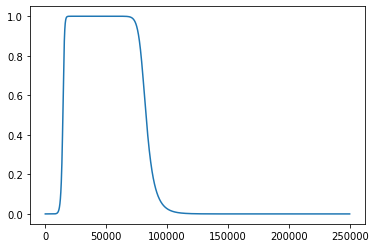

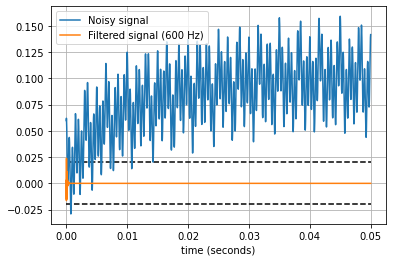

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 500000.0
    lowcut = 15000.0
    highcut = 80000.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [10]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="orden = %d" % order)
        print(w)
        print("H")
        print(abs(h))


    # Filter a noisy signal.
    T = 0.05
    nsamples = int(T * fs)
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=10)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()


run()

## Importación de librerias

In [ ]:
import openpyxl
import os
!pip install pydub
!pip install essentia
from pydub import AudioSegment
from math import * 
import IPython
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import  sklearn
import essentia, essentia.standard as ess
from scipy import fftpack

     |████████████████████████████████| 12.0MB 333kB/s 


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from tabulate import tabulate


# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
def modulo(a, b):
  '''Funcion que calcula el
  residuo (modulo) de una division'''
  residuo = 0
  x = a // b
  residuo = a - (x * b)
  return residuo

# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def plot_labels(n_folds, n_classes, list_labels):
    ind = np.arange(n_folds)
    width = 0.15
    
    countings = []
    for labels in list_labels:
        labels = np.array(labels)
        countings.append([np.count_nonzero(labels == x) for x in range(n_classes)])
    
    class_bars = []
    for cls in range(n_classes):
        class_bars.append([l[cls] for l in countings])
    
    fig, ax = pl.subplots()
    i = 0
    for class_bar in class_bars:
        ax.bar(ind + width*i, class_bar, width, label='Clase '+str(i))
        i += 1
        
    ax.set_xticks(ind + 2*width / 3)
    ax.set_xticklabels(['Pliegue {}'.format(k) for k in range(n_folds)])
    pl.legend(loc="best")
    pl.title("Etiquetas")
    
def list_cm(cm,classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
      row_0 =['','Valor','Verdadero']
      row_1 =['-',classes[0],classes[1]]
      row_2 =[classes[0],cm[0,0],cm[1,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1]]
      table = zip(row_0,row_1, row_2, row_3)
      headers = ['', '', 'Valor', 'Predicho']  
      return print(tabulate(table, headers=headers, floatfmt=".4f"))
    else:
      row_0 =['','Valor','Verdadero','']
      row_1 =['-',classes[0],classes[1],classes[2]]
      row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
      row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
      table = zip(row_0,row_1, row_2, row_3, row_4)
      headers = ['', '', 'Valor', 'Predicho', '']  
      return print(tabulate(table, headers=headers, floatfmt=".4f"))  

## Seleccion de la ubicacion de los audios 

In [ ]:

here_path = os.path.dirname(os.path.realpath('/content/drive/My Drive/Consolidado/MAESTRIA/PROPUESTA/AVANCES/FRAGMENTOS/'))
wav_file_name = 'FRAGMENTOS/M500_20180213_182812.wav'   ## AUDIO SIN RUIDOS
wav_file_name_2 = 'FRAGMENTOS/M500_20190606_183124.wav' ## AUDIO CON RUIDOS
#name = 'M500_20180213_182812'
#name_1 = 'M500_20190606_183124'
path ='/content/drive/My Drive/Consolidado/MAESTRIA/PROPUESTA/AVANCES/FRAGMENTOS/'
wave_file_path = os.path.join(here_path, wav_file_name)
wave_file_path_2 = os.path.join(here_path, wav_file_name_2)



## Seleccion de los archivos de etiquetas para el audio seleccionado

In [ ]:
excel_name = 'Etiquetas Originales.xlsx'
excel_path = path+excel_name
excel_document = openpyxl.load_workbook(excel_path)
sheet = excel_document.get_sheet_by_name('datos')

## Definición de las columnas con la información de los segmentos para audios sin riudos
multiple_cells = sheet['D3':'E833']
## Definición de las columnas con la información de los segmentos para audios ruidos
multiple_cells_ruido = sheet['D834':'E4427']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  after removing the cwd from sys.path.


## Recorte de audio en los fragmentos etiquetados
Se adelanta el recorte del audio original en los fragmentos de audio de interes, tomando como referencia las etiquetas realizadas, cada fragmento se nombra de la siguiente forma:

1.   Nombre audio orignal
2.   Numero consecutivo
3.   Milisegundos de inicio
3.   Milisegundo de fin

El nombre de cada Fragmento se guarda en la fila correspondiente a las etiquetas, con esto se actualiza la información de las etiquetas.

In [ ]:
## LEE EL AUDIO SIN RUIDO Y LO FRAGMENTA DE ACUERDO A LOS DATOS DEL ARCHIVO DE EXCEL

print (wave_file_path)
song = AudioSegment.from_wav(wave_file_path)
j = 0
inicio=0
fin=0
col1=2
k=0
for row in multiple_cells:
    for cell in row:
        j=j+1
        if fmod(j, 2)!= 0:
          inicio=cell.value
        else:
          k=k+1
          fin = cell.value
          audio_frag = song[inicio:fin]
          name_audio=str(k)+'_'+name+'_'+str(inicio)+'_'+str(fin)+'.wav'
          file_path =path+'SIN_RUIDO/'+name_audio
          audio_frag.export(file_path, format="wav")
          col1=col1+1
          sheet['A'+str(col1)] = name_audio         
excel_document.save(excel_path)  

In [ ]:
## LEE EL AUDIO CON RUIDO Y LO FRAGMENTA DE ACUERDO A LOS DATOS DEL ARCHIVO DE EXCEL
print (wave_file_path)
song = AudioSegment.from_wav(wave_file_path_2)
j = 0
inicio=0
fin=0
col1=833
k=0
for row in multiple_cells_ruido:
    for cell in row:
        j=j+1
        if fmod(j, 2)!= 0:
          inicio=cell.value
        else:
          k=k+1
          fin = cell.value
          audio_frag = song[inicio:fin]
          name_audio=str(k)+'_'+name_1+'_'+str(inicio)+'_'+str(fin)+'.wav'
          file_path =path+'RUIDO/'+name_audio
          audio_frag.export(file_path, format="wav")
          col1=col1+1
          sheet['A'+str(col1)] = name_audio         
excel_document.save(excel_path)

## Cargue de los audios para el procesamiento

In [ ]:
# Carga los audios recortados
SR = 500000 # All audio files are saved like this
sr = 500000
from scipy.io import wavfile
def load_sounds_in_folder(foldername):
    """ Loads all sounds in a folder"""
    sounds = []
    sound_name = {}
    for filename in os.listdir(foldername):
        path = os.path.join(foldername,filename)
        X, sr = librosa.load(path,sr=None)
        sound_name[filename]=X
    return sound_name

In [ ]:
batsounds = load_sounds_in_folder(path+'/AUDIOS/SIN_RUIDO')

In [ ]:
batsounds_ruido = load_sounds_in_folder(path+'/AUDIOS/RUIDO')

In [ ]:
batsounds_prueba = load_sounds_in_folder(path+'/AUDIOS/Prueba')

In [ ]:
batsounds_prueba

{'115_M500_20180213_182812_254817_254825.wav': array([ 0.00457764,  0.00579834,  0.00558472, ..., -0.00265503,
         0.00344849,  0.00671387], dtype=float32),
 '116_M500_20180213_182812_254853_254860.wav': array([0.00030518, 0.00198364, 0.00210571, ..., 0.00213623, 0.0039978 ,
        0.00289917], dtype=float32),
 '117_M500_20180213_182812_254885_254895.wav': array([ 0.00543213,  0.00964355,  0.00915527, ..., -0.00387573,
        -0.00326538, -0.00161743], dtype=float32),
 '1813_M500_20190606_183124_132924_132934.wav': array([-0.00946045, -0.00814819, -0.00839233, ..., -0.01403809,
        -0.00186157,  0.0135498 ], dtype=float32),
 '20_M500_20180213_182812_242563_242573.wav': array([-0.00698853, -0.00759888, -0.00561523, ...,  0.00024414,
         0.00344849,  0.00820923], dtype=float32),
 '2778_M500_20190606_183124_183941_183962.wav': array([0.01275635, 0.01113892, 0.01022339, ..., 0.00283813, 0.00424194,
        0.00100708], dtype=float32),
 '3219_M500_20190606_183124_238392_2384

### Escritura de caracteristicas en archivo

In [ ]:
def write_excel_document(features,columna,fila,name):
  columnas =['S','T','U','V','W','X','Y','Z',
          'AA','AB','AC','AD','AE','AF','AG','AH','AI','AJ','AK','AL','AM','AN','AO','AP','AQ','AR','AS','AT','AU','AV','AW','AX','AY','AZ',
          'BA','BB','BC','BD','BE','BF','BG','BH','BI','BJ','BK','BL','BM','BN','BO','BP','BQ','BR','BS','BT','BU','BV','BW','BX','BY','BZ',
          'CA','CB','CC','CD','CE','CF','CG','CH','CI','CJ','CK','CL','CM','CN','CO','CP','CQ','CR','CS','CT','CU','CV','CW','CX','CY','CZ',
          'DA','DB','DC','DD','DE','DF','DG','DH','DI','DJ','DK','DL','DM','DN','DO','DP','DQ','DR','DS','DT','DU','DV','DW','DX','DY','DZ',
          'EA','EB','EC','ED','EE','EF','EG','EH','EI','EJ','EK','EL','EM','EN','EO','EP','EQ','ER','ES','ET','EU','EV','EW','EX','EY','EZ',
          'FA','FB','FC','FD','FE','FF','FG','FH','FI','FJ','FK','FL','FM','FN','FO','FP','FQ','FR','FS','FT','FU','FV','FW','FX','FY','FZ',
          'GA','GB','GC','GD','GE','GF','GG','GH','GI','GJ','GK','GL','GM','GN','GO','GP','GQ','GR','GS','GT','GU','GV','GW','GX','GY','GZ',
          'HA','HB','HC','HD','HE','HF','HG','HH','HI','HJ','HK','HL','HM','HN','HO','HP','HQ','HR','HS','HT','HU','HV','HW','HX','HY','HZ',
          'IA','IB','IC','ID','IE','IF','IG','IH','II','IJ','IK','IL','IM','IN','IO','IP','IQ','IR','IS','IT','IU','IV','IW','IX','IY','IZ',
          'JA','JB','JC','JD','JE','JF','JG','JH','JI','JJ','JK','JL','JM','JN','JO','JP','JQ','JR','JS','JT','JU','JV','JW','JX','JY','JZ',
          'KA','KB','KC','KD','KE','KF','KG','KH','KI','KJ','KK','KL','KM','KN','KO','KP','KQ','KR','KS','KT','KU','KV','KW','KX','KY','KZ',
          'LA','LB','LC','LD','LE','LF','LG','LH','LI','LJ','LK','LL','LM','LN','LO','LP','LQ','LR','LS','LT','LU','LV','LW','LX','LY','LZ',
          'MA','MB','MC','MD','ME','MF','MG','MH','MI','MJ','MK','ML','MM','MN','MO','MP','MQ','MR','MS','MT','MU','MV','MW','MX','MY','MZ',
          'NA','NB','NC','ND','NE','NF','NG','NH','NI','NJ','NK','NL','NM','NN','NO','NP','NQ','NR','NS','NT','NU','NV','NW','NX','NY','NZ',
          'OA','OB','OC','OD','OE','OF','OG','OH','OI','OJ','OK','OL','OM','ON','OO','OP','OQ','OR','OS','OT','OU','OV','OW','OX','OY','OZ',
          'PA','PB','PC','PD','PE','PF','PG','PH','PI','PJ','PK','PL','PM','PN','PO','PP','PQ','PR','PS','PT','PU','PV','PW','PX','PY','PZ',
          'QA','QB','QC','QD','QE','QF','QG','QH','QI','QJ','QK','QL','QM','QN','QO','QP','QQ','QR','QS','QT','QU','QV','QW','QX','QY','QZ',
          'RA','RB','RC','RD','RE','RF','RG','RH','RI','RJ','RK','RL','RM','RN','RO','RP','RQ','RR','RS','RT','RU','RV','RW','RX','RY','RZ',
          'SA','SB','SC','SD','SE','SF','SG','SH','SI','SJ','SK','SL','SM','SN','SO','SP','SQ','SR','SS','ST','SU','SV','SW','SX','SY','SZ',
          'TA','TB','TC','TD','TE','TF','TG','TH','TI','TJ','TK','TL','TM','TN','TO','TP','TQ','TR','TS','TT','TU','TV','TW','TX','TY','TZ',
          'UA','UB','UC','UD','UE','UF','UG','UH','UI','UJ','UK','UL','UM','UN','UO','UP','UQ','UR','US','UT','UU','UV','UW','UX','UY','UZ',
          'VA','VB','VC','VD','VE','VF','VG','VH','VI','VJ','VK','VL','VM','VN','VO','VP','VQ','VR','VS','VT','VU','VV','VW','VX','VY','VZ',
          'WA','WB','WC','WD','WE','WF','WG','WH','WI','WJ','WK','WL','WM','WN','WO','WP','WQ','WR','WS','WT','WU','WV','WW','WX','WY','WZ',
          'XA','XB','XC','XD','XE','XF','XG','XH','XI','XJ','XK','XL','XM','XN','XO','XP','XQ','XR','XS','XT','XU','XV','XW','XX','XY','XZ',
          'YA','YB','YC','YD','YE','YF','YG','YH','YI','YJ','YK','YL','YM','YN','YO','YP','YQ','YR','YS','YT','YU','YV','YW','YX','YY','YZ',
          'ZA','ZB','ZC','ZD','ZE','ZF','ZG','ZH','ZI','ZJ','ZK','ZL','ZM','ZN','ZO','ZP','ZQ','ZR','ZS','ZT','ZU','ZV','ZW','ZX','ZY','ZZ',
          'AAA','AAB','AAC','AAD','AAE','AAF','AAG','AAH','AAI','AAJ','AAK','AAL','AAM','AAN','AAO','AAP','AAQ','AAR','AAS','AAT','AAU','AAV','AAW','AAX','AAY','AAZ',
          'ABA','ABB','ABC','ABD','ABE','ABF','ABG','ABH','ABI','ABJ','ABK','ABL','ABM','ABN','ABO','ABP','ABQ','ABR','ABS','ABT','ABU','ABV','ABW','ABX','ABY','ABZ',
          'ACA','ACB','ACC','ACD','ACE','ACF','ACG','ACH','ACI','ACJ','ACK','ACL','ACM','ACN','ACO','ACP','ACQ','ACR','ACS','ACT','ACU','ACV','ACW','ACX','ACY','ACZ',
          'ADA','ADB','ADC','ADD','ADE','ADF','ADG','ADH','ADI','ADJ','ADK','ADL','ADM','ADN','ADO','ADP','ADQ','ADR','ADS','ADT','ADU','ADV','ADW','ADX','ADY','ADZ',
          'AEA','AEB','AEC','AED','AEE','AEF','AEG','AEH','AEI','AEJ','AEK','AEL','AEM','AEN','AEO','AEP','AEQ','AER','AES','AET','AEU','AEV','AEW','AEX','AEY','AEZ',
          'AFA','AFB','AFC','AFD','AFE','AFF','AFG','AFH','AFI','AFJ','AFK','AFL','AFM','AFN','AFO','AFP','AFQ','AFR','AFS','AFT','AFU','AFV','AFW','AFX','AFY','AFZ',
          'AGA','AGB','AGC','AGD','AGE','AGF','AGG','AGH','AGI','AGJ','AGK','AGL','AGM','AGN','AGO','AGP','AGQ','AGR','AGS','AGT','AGU','AGV','AGW','AGX','AGY','AGZ',
          'AHA','AHB','AHC','AHD','AHE','AHF','AHG','AHH','AHI','AHJ','AHK','AHL','AHM','AHN','AHO','AHP','AHQ','AHR','AHS','AHT','AHU','AHV','AHW','AHX','AHY','AHZ',
          'AIA','AIB','AIC','AID','AIE','AIF','AIG','AIH','AII','AIJ','AIK','AIL','AIM','AIN','AIO','AIP','AIQ','AIR','AIS','AIT','AIU','AIV','AIW','AIX','AIY','AIZ',
          'AJA','AJB','AJC','AJD','AJE','AJF','AJG','AJH','AJI','AJJ','AJK','AJL','AJM','AJN','AJO','AJP','AJQ','AJR','AJS','AJT','AJU','AJV','AJW','AJX','AJY','AJZ',
          'AKA','AKB','AKC','AKD','AKE','AKF','AKG','AKH','AKI','AKJ','AKK','AKL','AKM','AKN','AKO','AKP','AKQ','AKR','AKS','AKT','AKU','AKV','AKW','AKX','AKY','AKZ',
          'ALA','ALB','ALC','ALD','ALE','ALF','ALG','ALH','ALI','ALJ','ALK','ALL','ALM','ALN','ALO','ALP','ALQ','ALR','ALS','ALT','ALU','ALV','ALW','ALX','ALY','ALZ',
          'AMA','AMB','AMC','AMD','AME','AMF','AMG','AMH','AMI','AMJ','AMK','AML','AMM','AMN','AMO','AMP','AMQ','AMR','AMS','AMT','AMU','AMV','AMW','AMX','AMY','AMZ',
          'ANA','ANB','ANC','AND','ANE','ANF','ANG','ANH','ANI','ANJ','ANK','ANL','ANM','ANN','ANO','ANP','ANQ','ANR','ANS','ANT','ANU','ANV','ANW','ANX','ANY','ANZ',
          'AOA','AOB','AOC','AOD','AOE','AOF','AOG','AOH','AOI','AOJ','AOK','AOL','AOM','AON','AOO','AOP','AOQ','AOR','AOS','AOT','AOU','AOV','AOW','AOX','AOY','AOZ',
          'APA','APB','APC','APD','APE','APF','APG','APH','API','APJ','APK','APL','APM','APN','APO','APP','APQ','APR','APS','APT','APU','APV','APW','APX','APY','APZ',
          'AQA','AQB','AQC','AQD','AQE','AQF','AQG','AQH','AQI','AQJ','AQK','AQL','AQM','AQN','AQO','AQP','AQQ','AQR','AQS','AQT','AQU','AQV','AQW','AQX','AQY','AQZ',
          'ARA','ARB','ARC','ARD','ARE','ARF','ARG','ARH','ARI','ARJ','ARK','ARL','ARM','ARN','ARO','ARP','ARQ','ARR','ARS','ART','ARU','ARV','ARW','ARX','ARY','ARZ',
          'ASA','ASB','ASC','ASD','ASE','ASF','ASG','ASH','ASI','ASJ','ASK','ASL','ASM','ASN','ASO','ASP','ASQ','ASR','ASS','AST','ASU','ASV','ASW','ASX','ASY','ASZ',
          'ATA','ATB','ATC','ATD','ATE','ATF','ATG','ATH','ATI','ATJ','ATK','ATL','ATM','ATN','ATO','ATP','ATQ','ATR','ATS','ATT','ATU','ATV','ATW','ATX','ATY','ATZ',
          'AUA','AUB','AUC','AUD','AUE','AUF','AUG','AUH','AUI','AUJ','AUK','AUL','AUM','AUN','AUO','AUP','AUQ','AUR','AUS','AUT','AUU','AUV','AUW','AUX','AUY','AUZ',
          'AVA','AVB','AVC','AVD','AVE','AVF','AVG','AVH','AVI','AVJ','AVK','AVL','AVM','AVN','AVO','AVP','AVQ','AVR','AVS','AVT','AVU','AVV','AVW','AVX','AVY','AVZ',
          'AWA','AWB','AWC','AWD','AWE','AWF','AWG','AWH','AWI','AWJ','AWK','AWL','AWM','AWN','AWO','AWP','AWQ','AWR','AWS','AWT','AWU','AWV','AWW','AWX','AWY','AWZ',
          'AXA','AXB','AXC','AXD','AXE','AXF','AXG','AXH','AXI','AXJ','AXK','AXL','AXM','AXN','AXO','AXP','AXQ','AXR','AXS','AXT','AXU','AXV','AXW','AXX','AXY','AXZ',
          'AYA','AYB','AYC','AYD','AYE','AYF','AYG','AYH','AYI','AYJ','AYK','AYL','AYM','AYN','AYO','AYP','AYQ','AYR','AYS','AYT','AYU','AYV','AYW','AYX','AYY','AYZ',
          'AZA','AZB','AZC','AZD','AZE','AZF','AZG','AZH','AZI','AZJ','AZK','AZL','AZM','AZN','AZO','AZP','AZQ','AZR','AZS','AZT','AZU','AZV','AZW','AZX','AZY','AZZ',
          ]
  for feature in features:
    if (fila==3):
      sheet[columnas[columna]+str(fila-1)] = name+'_'+str(columna)
    sheet[columnas[columna]+str(fila)] = feature
    columna=columna+1
  return columna

### Filtra las señales de audio

In [ ]:
from scipy.signal import butter, sosfilt, sosfreqz
def butter_bandpass(lowcut, highcut, fs, order=9):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

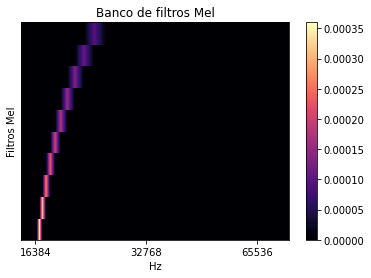

In [ ]:
melfb=librosa.filters.mel(sr=500000,n_mels=10, n_fft = 2048, fmin=15000, fmax=80000 )
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(melfb, sr=500000, x_axis='mel', ax=ax, fmin=15000,fmax=80000)
ax.set(ylabel='Filtros Mel', title='Banco de filtros Mel')
fig.colorbar(img, ax=ax)

## **Ejemplo de la aplicacion del filtro**



In [ ]:
Busqueda
115_M500_20180213_182812_254817_254825.wav    CF_FM
116_M500_20180213_182812_254853_254860.wav    FM
117_M500_20180213_182812_254885_254895.wav    QCF

ENFOQUE
1813_M500_20190606_183124_132924_132934.wav   QCF
20_M500_20180213_182812_242563_242573.wav     FM
3501_M500_20190606_183124_284220_284229.wav   CF_FM

Terminal
35_M500_20180213_182812_242811_242821.wav

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


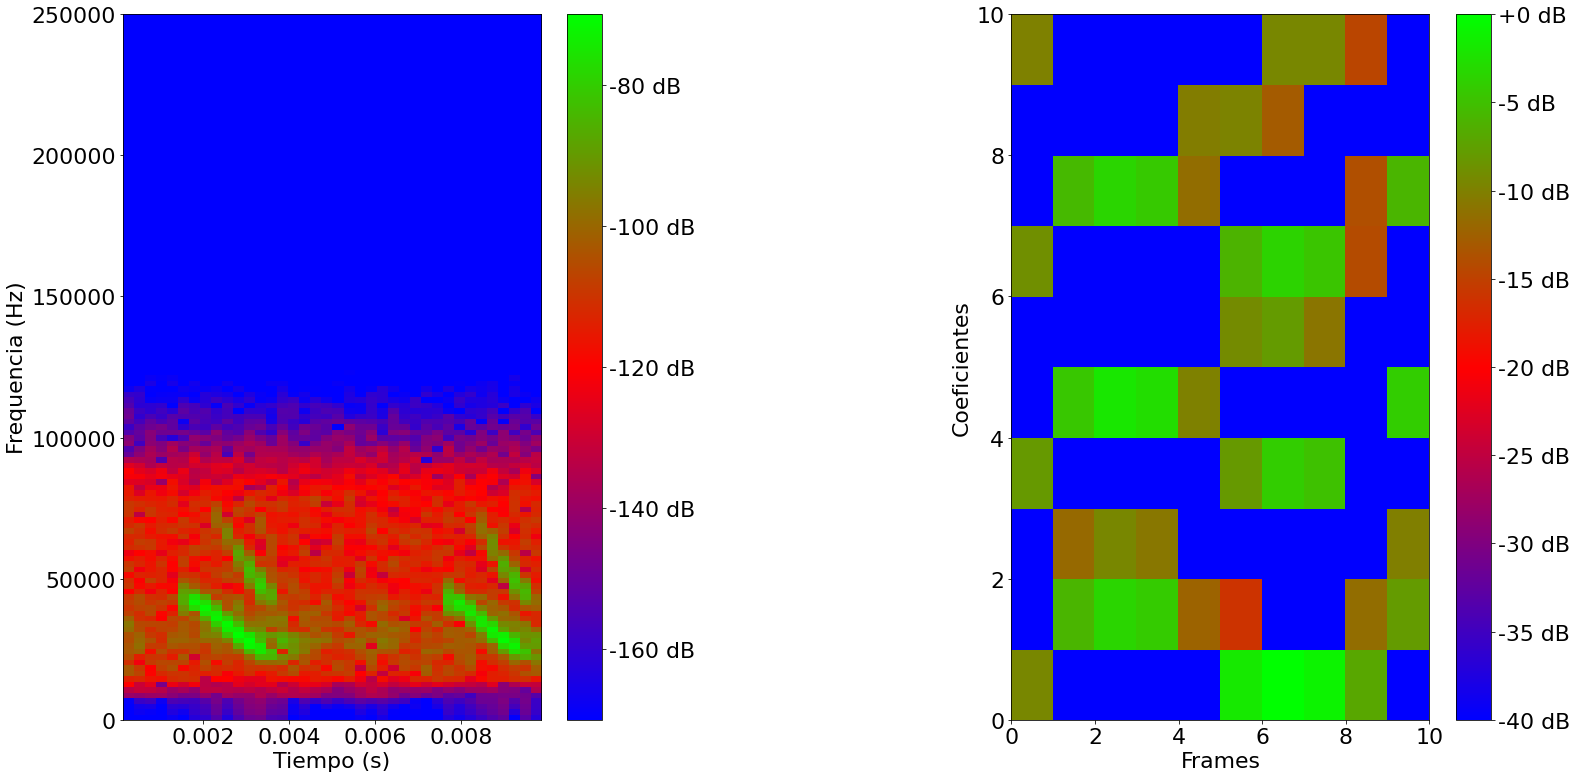

In [ ]:
Busqueda_CFFM='115_M500_20180213_182812_254817_254825.wav'##    CF_FM
Busqueda_FM='116_M500_20180213_182812_254853_254860.wav'##    FM
Busqueda_QCF='117_M500_20180213_182812_254885_254895.wav' ##    QCF

ENFOQUE_CFFM='3501_M500_20190606_183124_284220_284229.wav'
ENFOQUE_FM='20_M500_20180213_182812_242563_242573.wav'
ENFOQUE_QCF='1813_M500_20190606_183124_132924_132934.wav'

TERMINAL_FM='35_M500_20180213_182812_242811_242821.wav' 

plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(20, 10))
#plt.subplots_adjust(left=0.01, bottom=0.01, top=0.99, right=0.99, wspace = 2.9,hspace = 0.2)
plt.subplot(1, 2, 2)
## Cargue del audio y filtro
sound = batsounds_prueba[TERMINAL_FM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,10)
#bat_features = librosa.feature.chroma_stft(y=sound1, sr=sr)
bat_mfcc_features = librosa.feature.mfcc(sound1, sr=sr, n_mfcc=10)
bat_features=librosa.feature.delta(bat_mfcc_features,mode='nearest',order=2)
S_dB = librosa.power_to_db(bat_features,ref=np.max)
librosa.display.specshow(S_dB,y_axis='frames',x_axis='frames',cmap=plt.cm.brg)

#bat_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
#S_dB = librosa.power_to_db(bat_features, ref=np.max)
#librosa.display.specshow(S_dB, x_axis='frames',y_axis='chroma', sr=sr,fmin=15000, fmax=80000,cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
plt.tight_layout()
#plt.title('FASE DE BUSQUEDA: ')
#plt.legend(title='CF_FM')

#sound1 = batsounds_prueba[TERMINAL_FM]
plt.subplot(1, 2, 1)
pxx,  freq, t, cax = plt.specgram(sound1, Fs=sr,cmap=plt.cm.brg)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
#plt.title('FASE TERMINAL: ')
##plt.legend(title='FM')

plt.subplots_adjust(left=0.01, bottom=0.01, top=0.99, right=0.99, wspace = 0.7,hspace = 0.2)
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


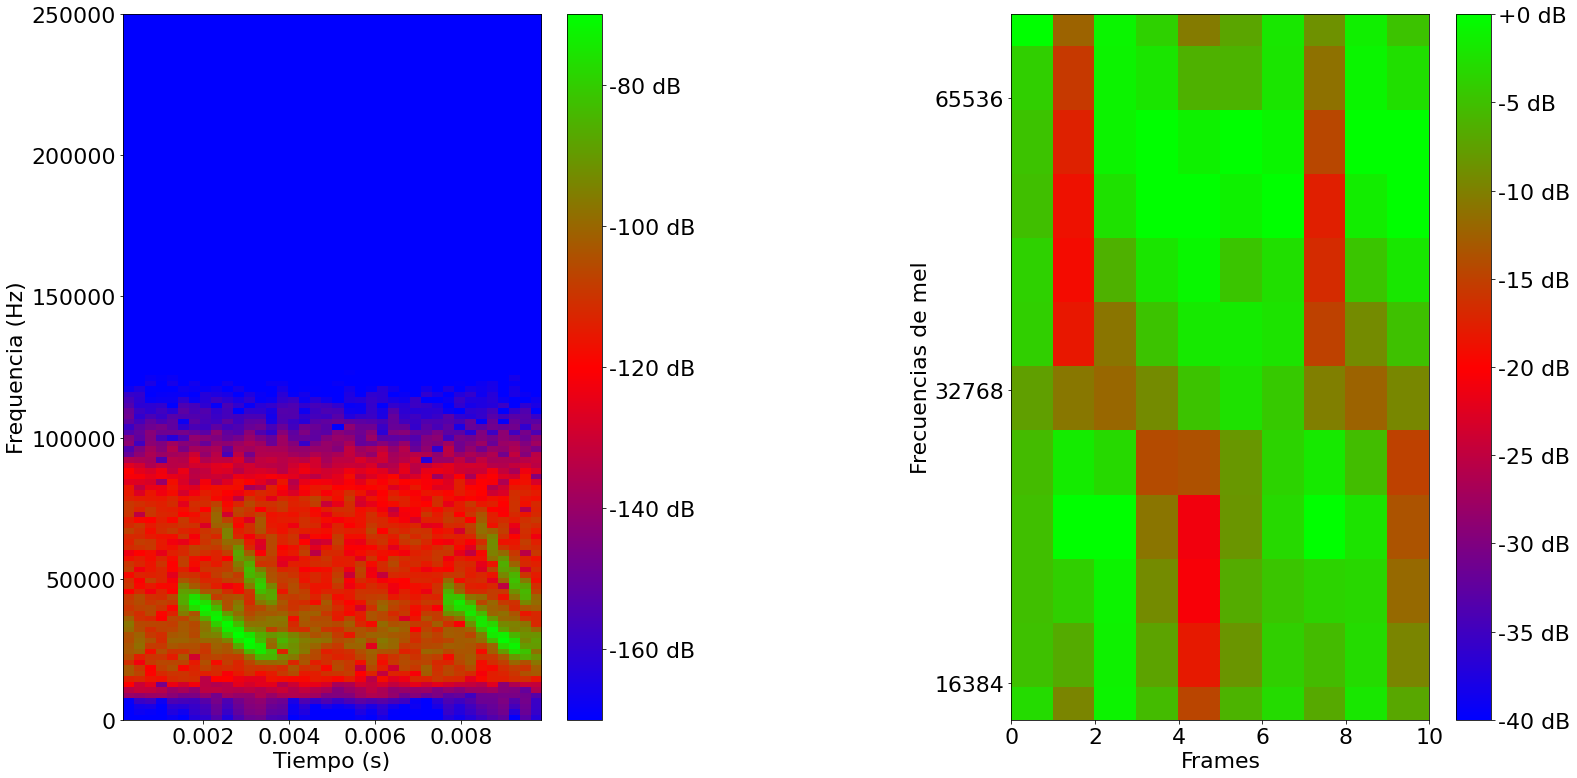

In [ ]:
Busqueda_CFFM='115_M500_20180213_182812_254817_254825.wav'##    CF_FM
Busqueda_FM='116_M500_20180213_182812_254853_254860.wav'##    FM
Busqueda_QCF='117_M500_20180213_182812_254885_254895.wav' ##    QCF

ENFOQUE_CFFM='3501_M500_20190606_183124_284220_284229.wav'
ENFOQUE_FM='20_M500_20180213_182812_242563_242573.wav'
ENFOQUE_QCF='1813_M500_20190606_183124_132924_132934.wav'

TERMINAL_FM='35_M500_20180213_182812_242811_242821.wav' 

plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(20, 10))
#plt.subplots_adjust(left=0.01, bottom=0.01, top=0.99, right=0.99, wspace = 2.9,hspace = 0.2)
plt.subplot(1, 2, 2)
## Cargue del audio y filtro
sound = batsounds_prueba[TERMINAL_FM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,10)
bat_features = librosa.feature.chroma_stft(y=sound1, sr=sr)
#S_dB = librosa.power_to_db(chroma_stft,ref=np.max)
#librosa.display.specshow(S_dB, y_axis='chroma',x_axis='frames',cmap=plt.cm.brg)



#bat_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_features, ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',
                      y_axis='mel', sr=sr,fmin=15000,
                          fmax=80000,cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
plt.tight_layout()
#plt.title('FASE DE BUSQUEDA: ')
#plt.legend(title='CF_FM')

#sound1 = batsounds_prueba[TERMINAL_FM]
plt.subplot(1, 2, 1)
pxx,  freq, t, cax = plt.specgram(sound1, Fs=sr,cmap=plt.cm.brg)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
#plt.title('FASE TERMINAL: ')
##plt.legend(title='FM')

plt.subplots_adjust(left=0.01, bottom=0.01, top=0.99, right=0.99, wspace = 0.7,hspace = 0.2)
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(4000,)
[ 0.00036621  0.00054932  0.0022583  ... -0.0017395  -0.00253296
 -0.00256348]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


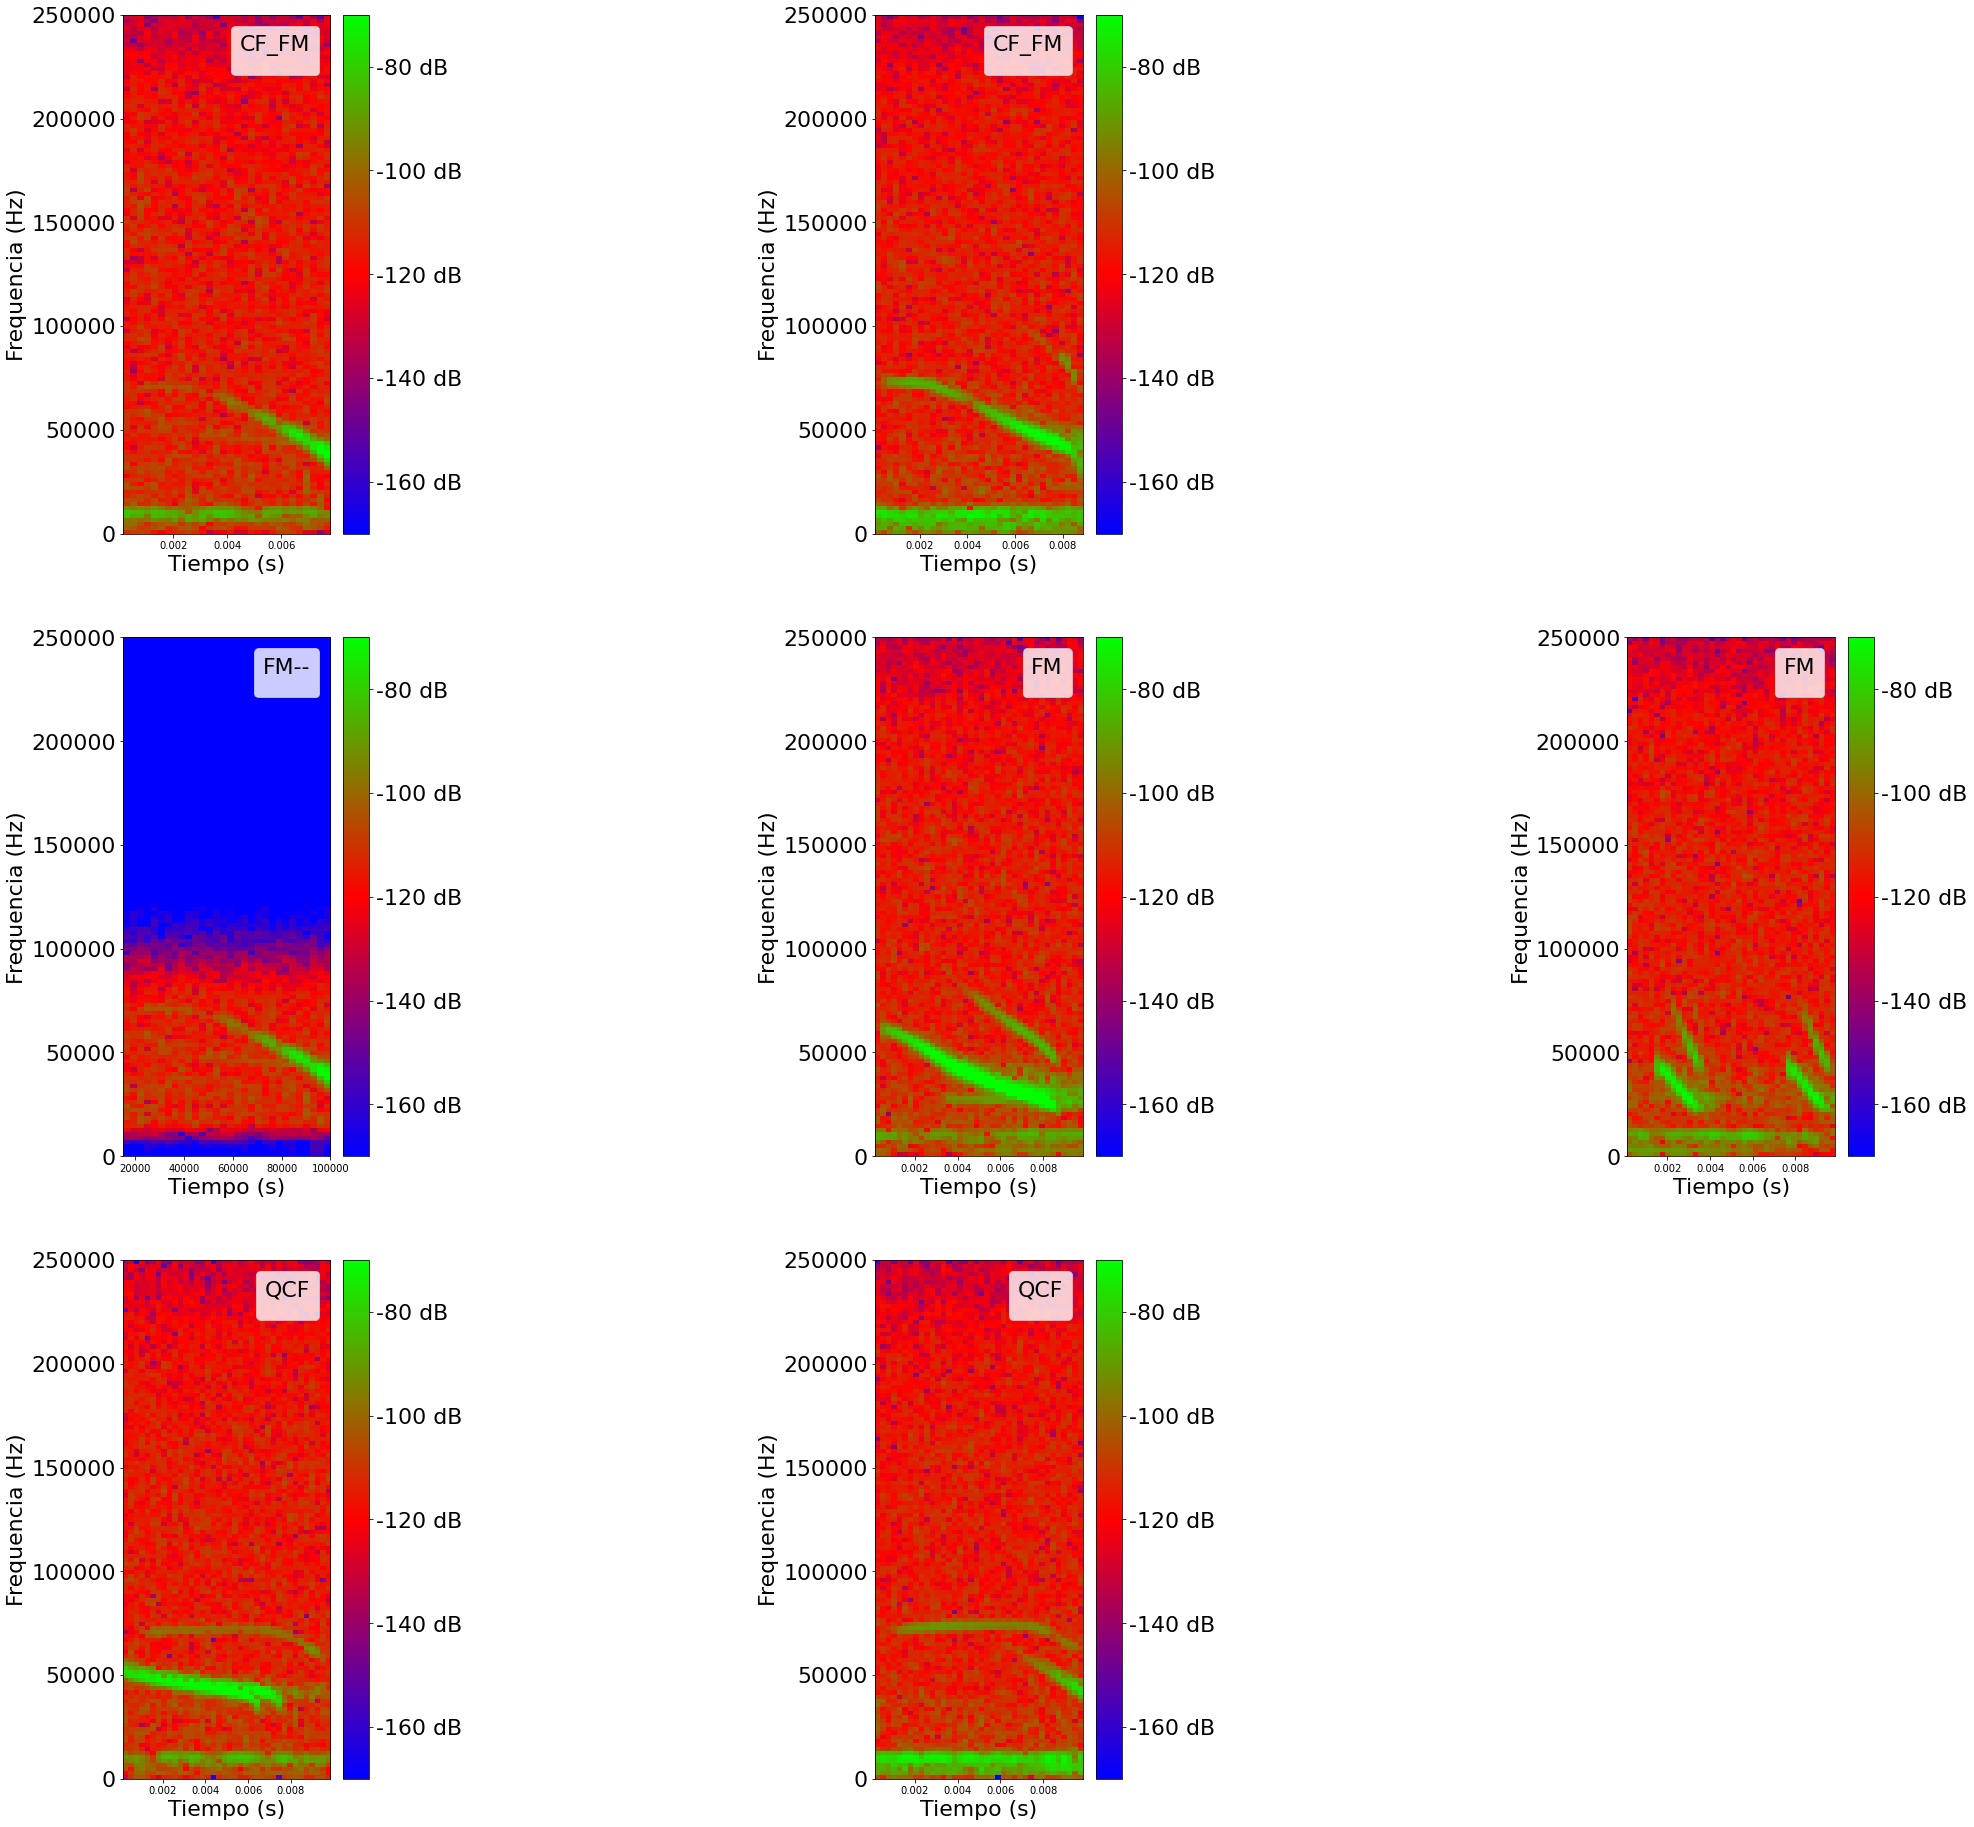

In [ ]:
import numpy as np
from scipy import fftpack

Busqueda_CFFM='115_M500_20180213_182812_254817_254825.wav'##    CF_FM
Busqueda_FM='116_M500_20180213_182812_254853_254860.wav'##    FM
Busqueda_QCF='117_M500_20180213_182812_254885_254895.wav' ##    QCF

ENFOQUE_CFFM='3501_M500_20190606_183124_284220_284229.wav'
ENFOQUE_FM='20_M500_20180213_182812_242563_242573.wav'
ENFOQUE_QCF='1813_M500_20190606_183124_132924_132934.wav'

TERMINAL_FM='35_M500_20180213_182812_242811_242821.wav' 
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rc('ytick', labelsize=22) 
plt.rc('xtick', labelsize=10) 
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(25, 25))
plt.subplot(3, 3, 1)
## Cargue del audio y filtro
sound = batsounds_prueba[Busqueda_CFFM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,10)
print(sound.shape)
plt.specgram(sound, Fs=sr, cmap=plt.cm.brg)
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
plt.legend(title='CF_FM')

sound = batsounds_prueba[Busqueda_FM]
sound2= sound[1000:-100,]
print(sound2)
plt.subplot(3, 3, 4)
plt.specgram(sound1, Fs=sr, cmap=plt.cm.brg,xextent=(15000,100000))
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
#plt.title('BUSQUEDA FM: '+ Busqueda_FM)
plt.legend(title='FM--')

sound = batsounds_prueba[Busqueda_QCF]
plt.subplot(3, 3, 7)
plt.specgram(sound, Fs=sr, cmap=plt.cm.brg)
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
#plt.title('BUSQUEDA QCF: '+ Busqueda_QCF)
plt.legend(title='QCF')


sound = batsounds_prueba[ENFOQUE_CFFM]
plt.subplot(3, 3, 2)
plt.specgram(sound, Fs=sr, cmap=plt.cm.brg)
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
#plt.title('FASE DE ENFOQUE')
plt.legend(title='CF_FM')

sound = batsounds_prueba[ENFOQUE_FM]
plt.subplot(3, 3, 5)
plt.specgram(sound, Fs=sr, cmap=plt.cm.brg)
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
#plt.title('BUSQUEDA FM: '+ Busqueda_FM)
plt.legend(title='FM')

sound = batsounds_prueba[ENFOQUE_QCF]
plt.subplot(3, 3, 8)
plt.specgram(sound, Fs=sr, cmap=plt.cm.brg)
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
#plt.title('BUSQUEDA QCF: '+ Busqueda_QCF)
plt.legend(title='QCF')


sound = batsounds_prueba[TERMINAL_FM]
plt.subplot(3, 3, 6)
pxx,  freq, t, cax = plt.specgram(sound, Fs=sr,cmap=plt.cm.brg)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
#plt.title('FASE TERMINAL: ')
plt.legend(title='FM')

plt.subplots_adjust(left=0.01, bottom=0.01, top=0.99, right=0.99, wspace = 1.9,hspace = 0.2)
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.show()




In [ ]:
from numpy import array, diff, where, split
from scipy import arange
#import soundfile
import numpy, scipy
import pylab
import copy
import matplotlib
#matplotlib.use('tkagg')

def findPeak(magnitude_values, noise_level=200):
    
    splitter = 0
    # zero out low values in the magnitude array to remove noise (if any)
    magnitude_values = numpy.asarray(magnitude_values)        
    low_values_indices = magnitude_values < noise_level  # Where values are low
    magnitude_values[low_values_indices] = 0  # All low values will be zero out
    
    indices = []
    
    flag_start_looking = False
    
    both_ends_indices = []
    
    length = len(magnitude_values)
    for i in range(length):
        if magnitude_values[i] != splitter:
            if not flag_start_looking:
                flag_start_looking = True
                both_ends_indices = [0, 0]
                both_ends_indices[0] = i
        else:
            if flag_start_looking:
                flag_start_looking = False
                both_ends_indices[1] = i
                # add both_ends_indices in to indices
                indices.append(both_ends_indices)
                
    return indices

def extractFrequency(indices, freq_threshold=2):
    
    extracted_freqs = []
    
    for index in indices:
        freqs_range = freq_bins[index[0]: index[1]]
        avg_freq = round(numpy.average(freqs_range))
        
        if avg_freq not in extracted_freqs:
            extracted_freqs.append(avg_freq)

    # group extracted frequency by nearby=freq_threshold (tolerate gaps=freq_threshold)
    group_similar_values = split(extracted_freqs, where(diff(extracted_freqs) > freq_threshold)[0]+1 )
    
    # calculate the average of similar value
    extracted_freqs = []
    for group in group_similar_values:
        extracted_freqs.append(round(numpy.average(group)))
    
    print("freq_components", extracted_freqs)
    return extracted_freqs




ENFOQUE_CFFM='3501_M500_20190606_183124_284220_284229.wav'
ENFOQUE_FM='20_M500_20180213_182812_242563_242573.wav'
ENFOQUE_QCF='1813_M500_20190606_183124_132924_132934.wav'

TERMINAL_FM='35_M500_20180213_182812_242811_242821.wav' 


sound = batsounds_prueba[TERMINAL_FM]
audio_samples = sound
sample_rate  = sr
number_samples = len(audio_samples)
print('Audio Samples: ', audio_samples)
print('Number of Sample', number_samples)
print('Sample Rate: ', sample_rate)

# duration of the audio file
duration = round(number_samples/sample_rate, 2)
print('Audio Duration: {0}s'.format(duration))

# list of possible frequencies bins
freq_bins = arange(number_samples) * sample_rate/number_samples
print('Frequency Length: ', len(freq_bins))
print('Frequency bins: ', freq_bins)

#     # FFT calculation
fft_data = scipy.fft(audio_samples)
print('FFT Length: ', len(fft_data))
print('FFT data: ', fft_data)

freq_bins = freq_bins[range(number_samples//2)]      
normalization_data = fft_data/number_samples
magnitude_values = normalization_data[range(len(fft_data)//2)]
magnitude_values = numpy.abs(magnitude_values)
    
indices = findPeak(magnitude_values=magnitude_values, noise_level=200)
frequencies = extractFrequency(indices=indices)
print("frequencies:", frequencies)

x_asis_data = freq_bins
y_asis_data = magnitude_values

pylab.plot(x_asis_data, y_asis_data, color='blue') # plotting the spectrum

pylab.xlabel('Freq (Hz)')
pylab.ylabel('|Magnitude - Voltage  Gain / Loss|')
pylab.show()


Audio Samples:  [-0.00695801 -0.0078125  -0.00662231 ... -0.0022583  -0.00271606
 -0.00424194]
Number of Sample 5000
Sample Rate:  500000
Audio Duration: 0.01s
Frequency Length:  5000
Frequency bins:  [0.000e+00 1.000e+02 2.000e+02 ... 4.997e+05 4.998e+05 4.999e+05]
FFT Length:  5000
FFT data:  [0.07641602+0.j         0.11692565-0.00016665j 0.11960043+0.00279916j ...
 0.11380695-0.00666214j 0.11960043-0.00279916j 0.11692565+0.00016665j]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

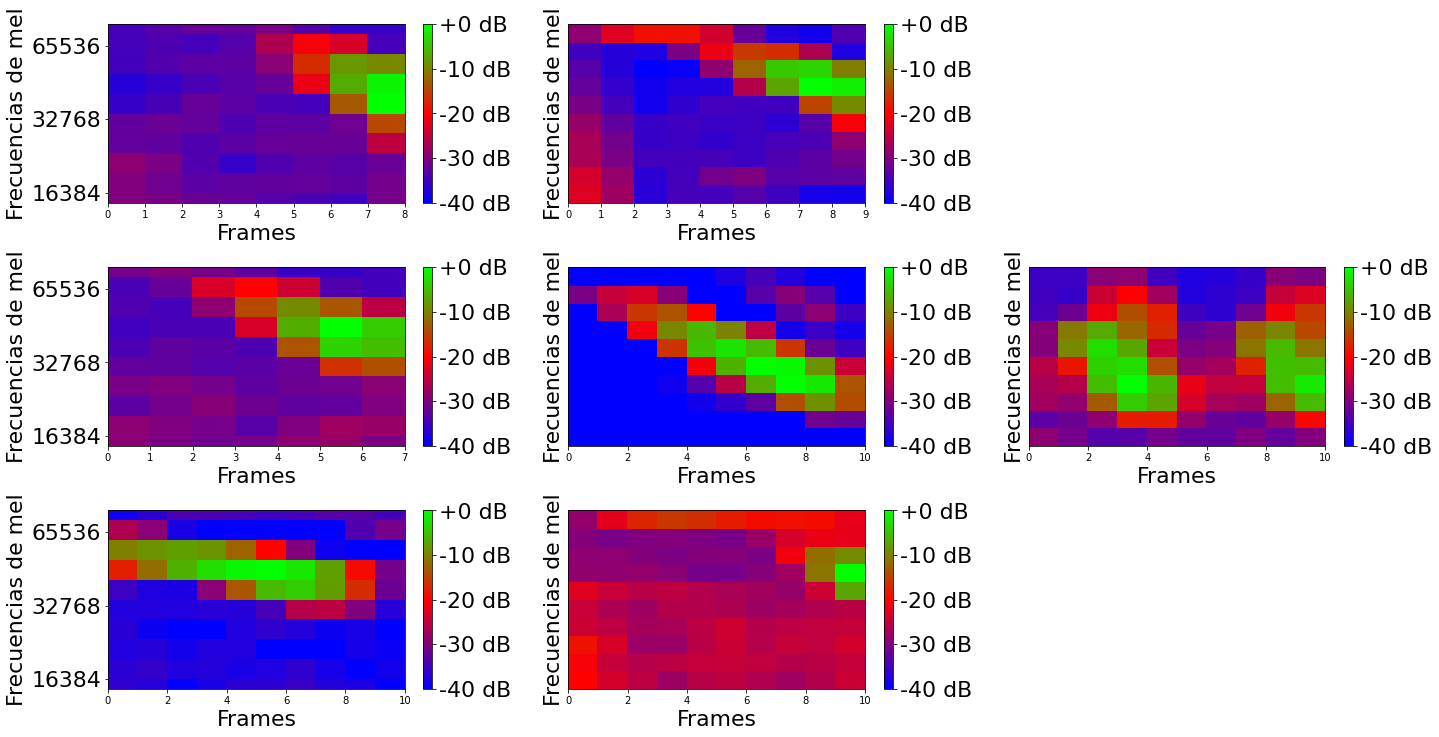

[15000.         18066.28659917 21759.38076557 26207.41394209
 31564.71008673 38017.13992312 45788.56970213 55148.62821367
 66422.06152397 80000.        ]
66.66666666666667


In [ ]:
import numpy as np
from scipy import fftpack

Busqueda_CFFM='115_M500_20180213_182812_254817_254825.wav'##    CF_FM
Busqueda_FM='116_M500_20180213_182812_254853_254860.wav'##    FM
Busqueda_QCF='117_M500_20180213_182812_254885_254895.wav' ##    QCF

ENFOQUE_CFFM='3501_M500_20190606_183124_284220_284229.wav'
ENFOQUE_FM='20_M500_20180213_182812_242563_242573.wav'
ENFOQUE_QCF='1813_M500_20190606_183124_132924_132934.wav'

TERMINAL_FM='35_M500_20180213_182812_242811_242821.wav' 
# Make plots appear inline, set custom plotting style
#%matplotlib inline
#import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.01, bottom=0.01, top=0.99, right=0.99, wspace = 2.9,hspace = 0.2)
plt.subplot(3, 3, 1)
## Cargue del audio y filtro
sound = batsounds_prueba[Busqueda_CFFM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,10)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_mels_features, ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',
                      y_axis='mel', sr=sr,fmin=15000,
                          fmax=80000,cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
plt.tight_layout()
#plt.title('FASE DE BUSQUEDA: ')
#plt.legend(title='CF_FM')

sound = batsounds_prueba[Busqueda_FM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,20)
plt.subplot(3, 3, 4)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_mels_features, ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',
                      y_axis='mel', sr=sr,fmin=15000,
                          fmax=80000,cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
#plt.title('BUSQUEDA FM: '+ Busqueda_FM)
#plt.legend(title='FM')

sound = batsounds_prueba[Busqueda_QCF]
sound1= butter_bandpass_filter(sound,15000,80000,sr,20)
plt.subplot(3, 3, 7)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_mels_features, ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',
                      y_axis='mel', sr=sr,fmin=15000,
                          fmax=80000,cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
#plt.legend(title='QCF')

sound = batsounds_prueba[ENFOQUE_CFFM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,20)
plt.subplot(3, 3, 2)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_mels_features, ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames'
                      , sr=sr,fmin=15000,
                          fmax=80000,cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
#plt.title('FASE DE ENFOQUE')
#plt.legend(title='CF_FM')

sound = batsounds_prueba[ENFOQUE_FM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,20)
plt.subplot(3, 3, 5)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_mels_features, ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',
                       sr=sr,fmin=15000,
                          fmax=80000,cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
#plt.legend(title='FM')

sound = batsounds_prueba[ENFOQUE_QCF]
sound1= butter_bandpass_filter(sound,15000,80000,sr,20)
plt.subplot(3, 3, 8)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_mels_features, ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',
                       sr=sr,fmin=15000,
                          fmax=80000,cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
#plt.legend(title='QCF')


sound = batsounds_prueba[TERMINAL_FM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,20)
plt.subplot(3, 3, 6)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_mels_features,ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',  fmin=15000, fmax=80000,
                          sr=sr,cmap=plt.cm.brg)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
#plt.title('FASE TERMINAL: ')
#plt.legend(title='FM')
plt.clim(-40, 0)
plt.show()
print(librosa.mel_frequencies(n_mels=10, fmin=15000, fmax=80000))



In [ ]:
bat_mels_features.tolist

<function ndarray.tolist>

In [ ]:
print(sound.shape)

(5000,)


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


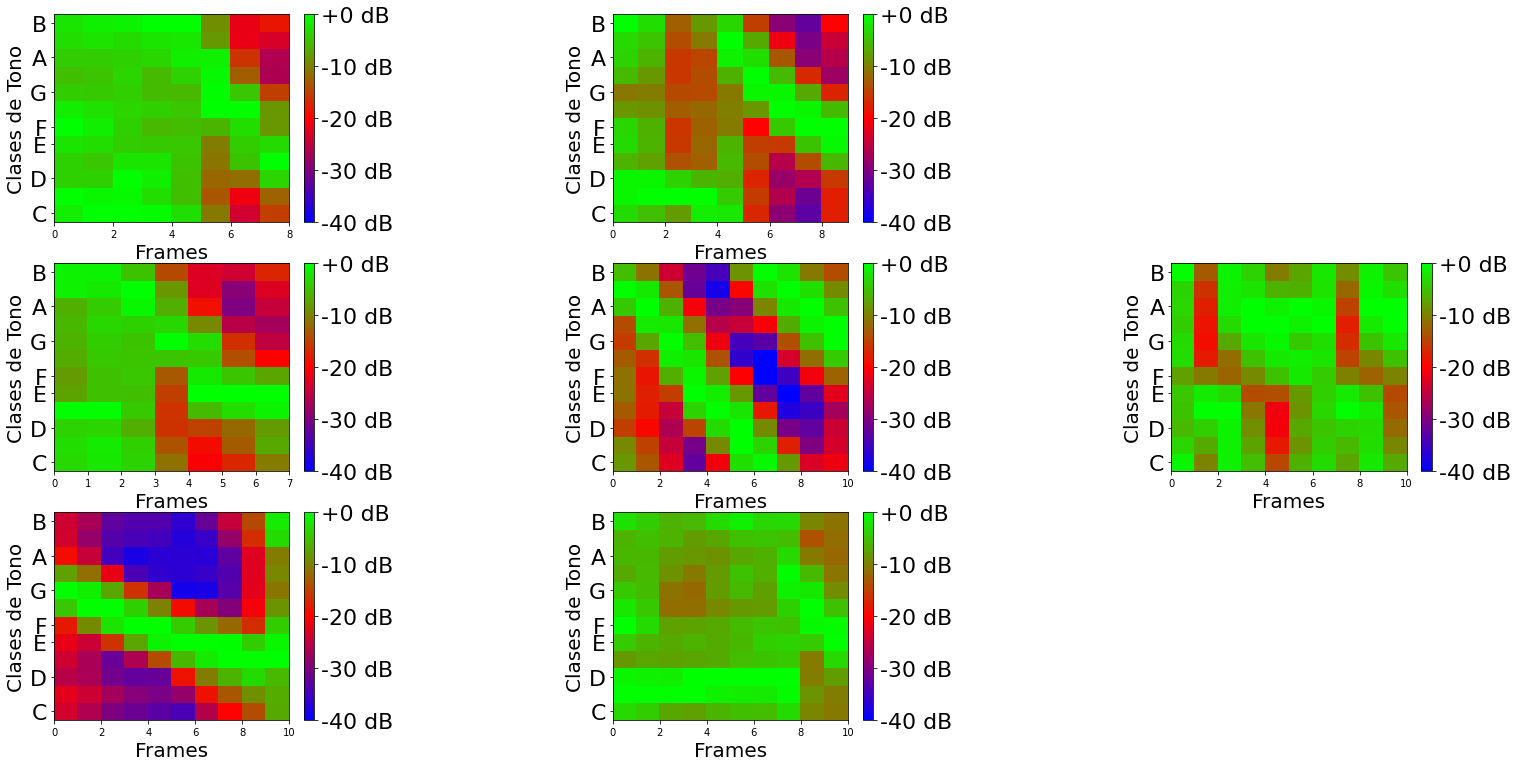

In [ ]:
import numpy as np
from scipy import fftpack

Busqueda_CFFM='115_M500_20180213_182812_254817_254825.wav'##    CF_FM
Busqueda_FM='116_M500_20180213_182812_254853_254860.wav'##    FM
Busqueda_QCF='117_M500_20180213_182812_254885_254895.wav' ##    QCF

ENFOQUE_CFFM='3501_M500_20190606_183124_284220_284229.wav'
ENFOQUE_FM='20_M500_20180213_182812_242563_242573.wav'
ENFOQUE_QCF='1813_M500_20190606_183124_132924_132934.wav'

TERMINAL_FM='35_M500_20180213_182812_242811_242821.wav' 
# Make plots appear inline, set custom plotting style
plt.rcParams.update({'font.size': 20})


plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.01, bottom=0.01, top=0.99, right=0.99, wspace = 0.9,hspace = 0.2)
plt.subplot(3, 3, 1)
## Cargue del audio y filtro
sound = batsounds_prueba[Busqueda_CFFM]
sound1= butter_bandpass_filter(sound,15000,80000,sr,20)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=10, fmin=15000, fmax=80000)
chroma_stft = librosa.feature.chroma_stft(y=sound1, sr=sr)
S_dB = librosa.power_to_db(chroma_stft,ref=np.max)
librosa.display.specshow(S_dB, y_axis='chroma',x_axis='frames',cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
#plt.title('FASE DE BUSQUEDA: ')
#plt.legend(title='CF_FM')

sound = batsounds_prueba[Busqueda_FM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 4)
chroma_stft = librosa.feature.chroma_stft(y=sound1, sr=sr)
S_dB = librosa.power_to_db(chroma_stft,ref=np.max)
librosa.display.specshow(S_dB, y_axis='chroma',x_axis='frames',cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
#plt.legend(title='FM')

sound = batsounds_prueba[Busqueda_QCF]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 7)
chroma_stft = librosa.feature.chroma_stft(y=sound1, sr=sr)
S_dB = librosa.power_to_db(chroma_stft,ref=np.max)
librosa.display.specshow(S_dB, y_axis='chroma',x_axis='frames',cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
#plt.legend(title='QCF')

sound = batsounds_prueba[ENFOQUE_CFFM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 2)
chroma_stft = librosa.feature.chroma_stft(y=sound1, sr=sr)
S_dB = librosa.power_to_db(chroma_stft,ref=np.max)
librosa.display.specshow(S_dB, y_axis='chroma',x_axis='frames',cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
#plt.title('FASE DE ENFOQUE')
#plt.legend(title='CF_FM')

sound = batsounds_prueba[ENFOQUE_FM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 5)
chroma_stft = librosa.feature.chroma_stft(y=sound1, sr=sr)
S_dB = librosa.power_to_db(chroma_stft,ref=np.max)
librosa.display.specshow(S_dB, y_axis='chroma',x_axis='frames',cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
#plt.legend(title='FM')

sound = batsounds_prueba[ENFOQUE_QCF]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 8)
chroma_stft = librosa.feature.chroma_stft(y=sound1, sr=sr)
S_dB = librosa.power_to_db(chroma_stft,ref=np.max)
librosa.display.specshow(S_dB, y_axis='chroma',x_axis='frames',cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
#plt.legend(title='QCF')


sound = batsounds_prueba[TERMINAL_FM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
fiter=librosa.filters.chroma(500000, 4096, octwidth=None)
plt.subplot(3, 3, 6)
chroma_stft = librosa.feature.chroma_stft(y=sound1, sr=sr)
S_dB = librosa.power_to_db(chroma_stft,ref=np.max)
librosa.display.specshow(S_dB, y_axis='chroma',x_axis='frames',cmap=plt.cm.brg)
plt.clim(-40, 0)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
#plt.title('FASE TERMINAL: ')
#plt.legend(title='FM')

plt.show()



In [ ]:

from math import log2, pow
A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
def pitch(freq):
 h = round(12*log2(freq/C0))
 octave = h // 12
 n = h % 12
 return name[n] + str(octave)
print(pitch(250000))

B13


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


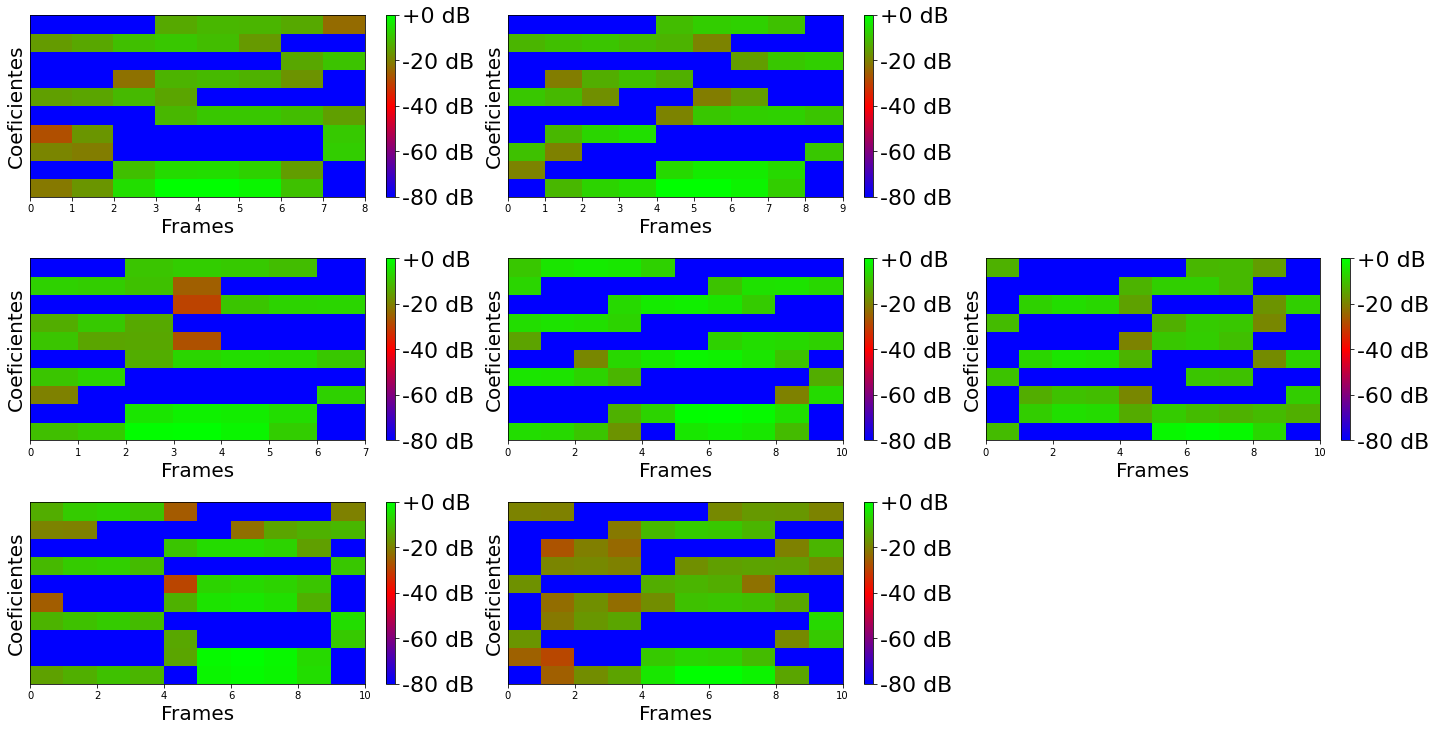

In [ ]:
import numpy as np
from scipy import fftpack

Busqueda_CFFM='115_M500_20180213_182812_254817_254825.wav'##    CF_FM
Busqueda_FM='116_M500_20180213_182812_254853_254860.wav'##    FM
Busqueda_QCF='117_M500_20180213_182812_254885_254895.wav' ##    QCF

ENFOQUE_CFFM='3501_M500_20190606_183124_284220_284229.wav'
ENFOQUE_FM='20_M500_20180213_182812_242563_242573.wav'
ENFOQUE_QCF='1813_M500_20190606_183124_132924_132934.wav'

TERMINAL_FM='35_M500_20180213_182812_242811_242821.wav' 
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.rc('legend', fontsize=15)    # legend fontsize


plt.figure(figsize=(20, 10),)
plt.subplot(3, 3, 1)
## Cargue del audio y filtro
sound = batsounds_prueba[Busqueda_CFFM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
mfcc_features = librosa.feature.mfcc(sound1, sr=sr, n_mfcc=10)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features, order=2,mode='nearest')
S_dB = librosa.power_to_db(bat_delta_mfcc,ref=np.max)
librosa.display.specshow(S_dB,sr=sr, x_axis='frames',cmap=plt.cm.brg)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
plt.tight_layout()
#plt.title('FASE DE BUSQUEDA: ')
#plt.legend(title='CF_FM')

sound = batsounds_prueba[Busqueda_FM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 4)
mfcc_features = librosa.feature.mfcc(sound1, sr=sr, n_mfcc=10)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features, order=2,mode='nearest')
S_dB = librosa.power_to_db(bat_delta_mfcc,ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',cmap=plt.cm.brg)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
#plt.legend(title='FM')

sound = batsounds_prueba[Busqueda_QCF]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 7)
mfcc_features = librosa.feature.mfcc(sound1, sr=sr, n_mfcc=10)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features, order=2,mode='nearest')
S_dB = librosa.power_to_db(bat_delta_mfcc,ref=np.max)
librosa.display.specshow(S_dB,sr=sr, x_axis='frames',cmap=plt.cm.brg)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
#plt.legend(title='QCF')




sound = batsounds_prueba[ENFOQUE_CFFM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 2)
mfcc_features = librosa.feature.mfcc(sound1, sr=sr, n_mfcc=10)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features, order=2,mode='nearest')
S_dB = librosa.power_to_db(bat_delta_mfcc,ref=np.max)
librosa.display.specshow(S_dB,sr=sr, x_axis='frames',cmap=plt.cm.brg)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
#plt.title('FASE DE ENFOQUE')
#plt.legend(title='CF_FM')

sound = batsounds_prueba[ENFOQUE_FM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 5)
mfcc_features = librosa.feature.mfcc(sound1, sr=sr, n_mfcc=10)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features, order=2,mode='nearest')
S_dB = librosa.power_to_db(bat_delta_mfcc,ref=np.max)
librosa.display.specshow(S_dB,sr=sr, x_axis='frames',cmap=plt.cm.brg)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
#plt.legend(title='FM')

sound = batsounds_prueba[ENFOQUE_QCF]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 8)
mfcc_features = librosa.feature.mfcc(sound1, sr=sr, n_mfcc=10)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features, order=2,mode='nearest')
S_dB = librosa.power_to_db(bat_delta_mfcc,ref=np.max)
librosa.display.specshow(S_dB,sr=sr, x_axis='frames',cmap=plt.cm.brg)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
#plt.legend(title='QCF')


sound = batsounds_prueba[TERMINAL_FM]
sound1= butter_bandpass_filter(sound,15000,100000,sr,20)
plt.subplot(3, 3, 6)
mfcc_features = librosa.feature.mfcc(sound1, sr=sr, n_mfcc=10)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features, order=2,mode='nearest')
S_dB = librosa.power_to_db(bat_delta_mfcc,ref=np.max)
librosa.display.specshow(S_dB,sr=sr, x_axis='frames',cmap=plt.cm.brg)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
#plt.title('FASE TERMINAL: ')
#plt.legend(title='FM')

plt.show()




In [ ]:
print(np.abs(sig_fft))

[0.01610557 0.0161062  0.01610808 ... 0.01611123 0.01610808 0.0161062 ]


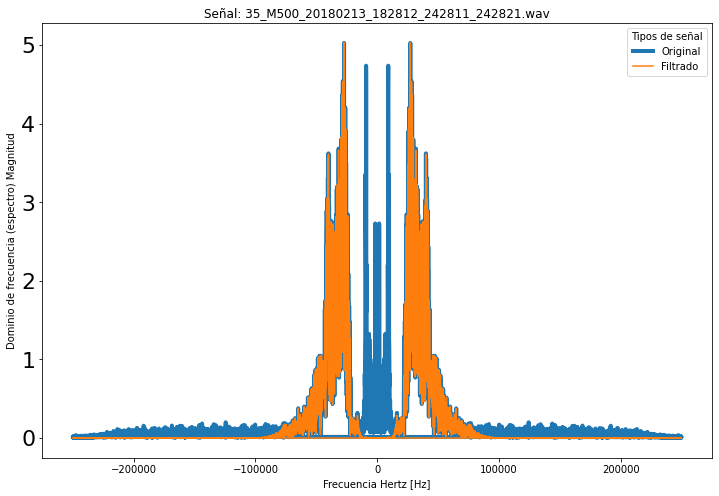

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


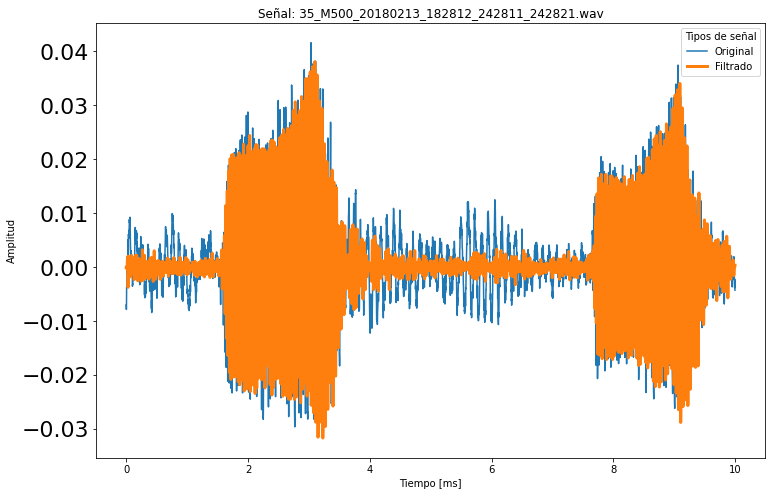

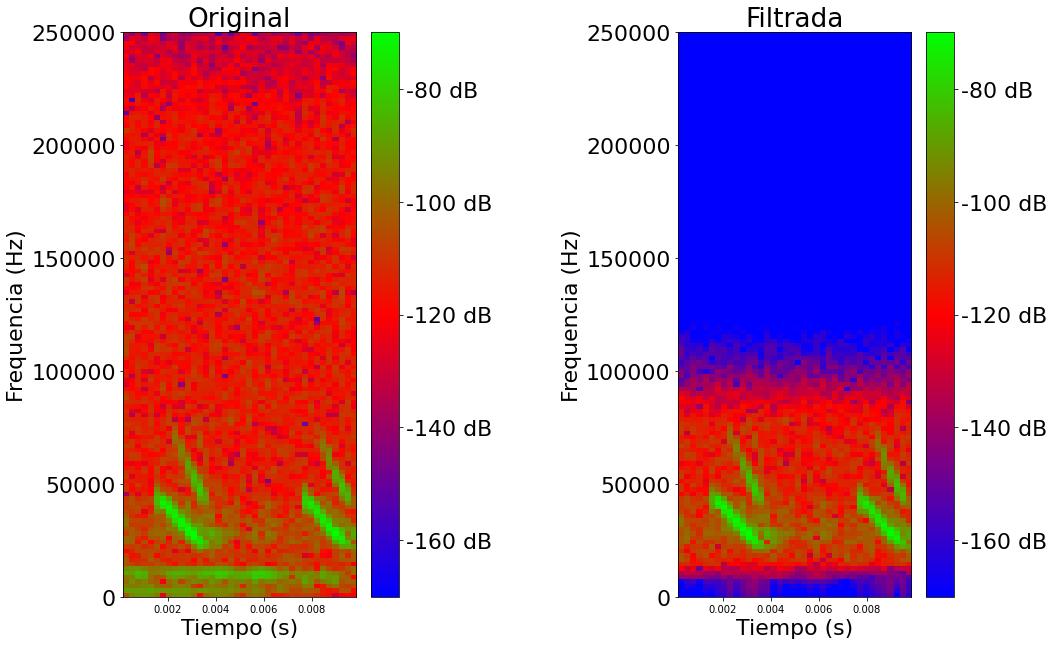

27200.0
Frecuencia pico: 27200.0


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


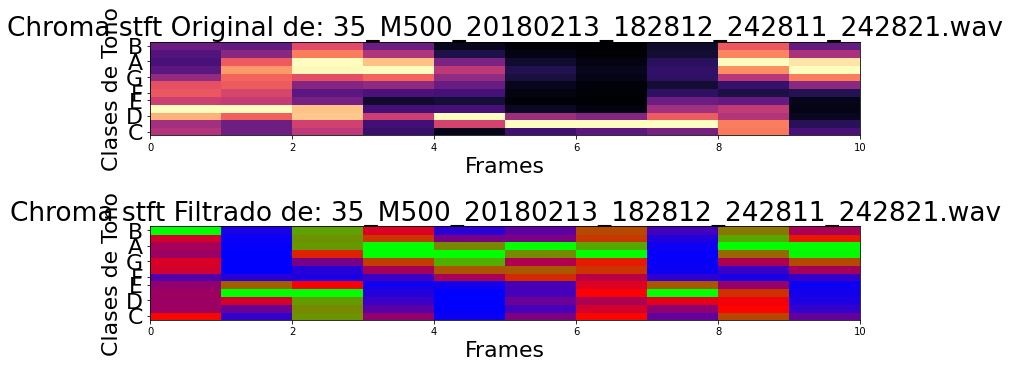

(12, 10)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=625
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=313
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=157
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=79
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=40
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=20
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spe

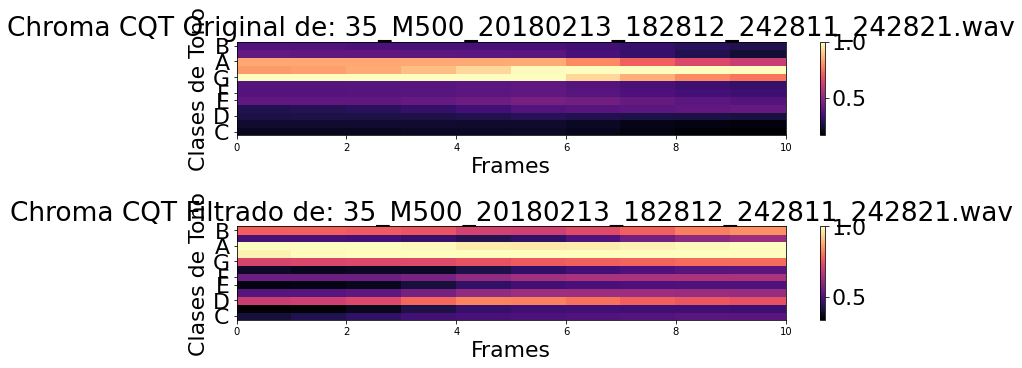

(12, 10)


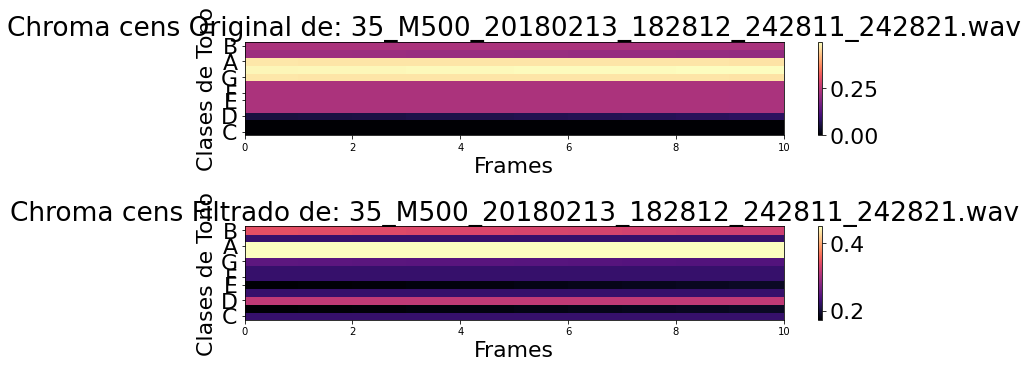

(12, 10)


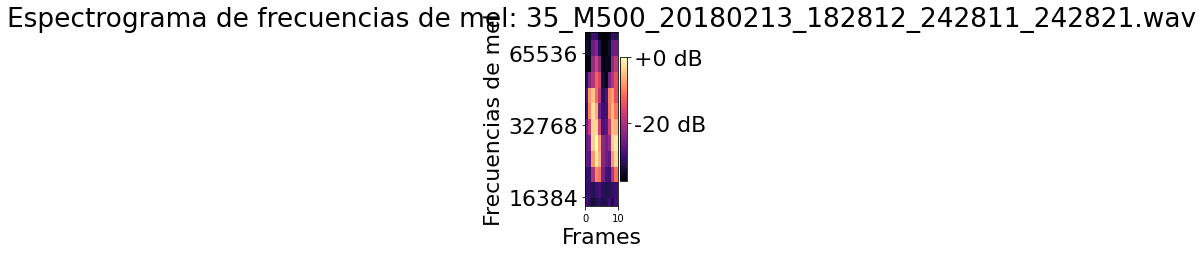

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


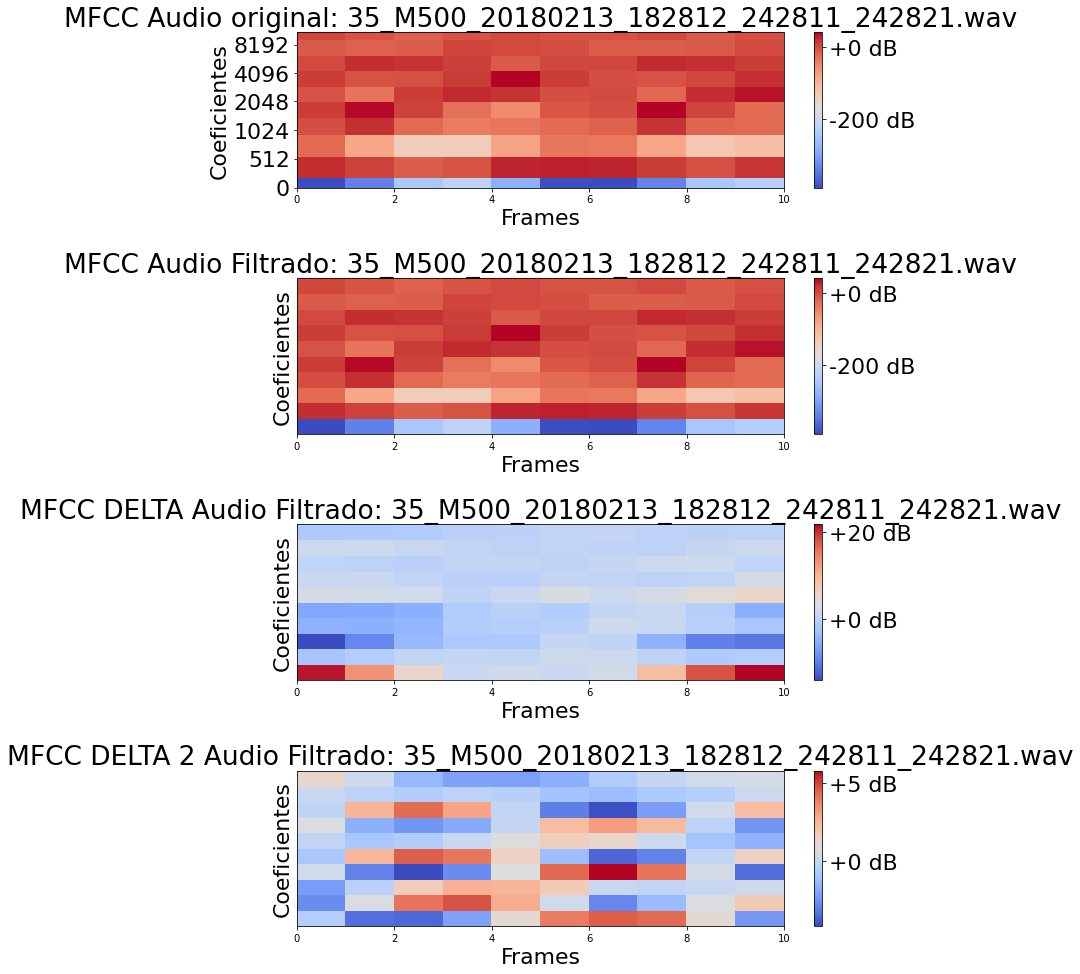

In [ ]:
import numpy as np
from scipy import fftpack
Busqueda_CFFM='115_M500_20180213_182812_254817_254825.wav'##    CF_FM
Busqueda_FM='116_M500_20180213_182812_254853_254860.wav'##    FM
Busqueda_QCF='117_M500_20180213_182812_254885_254895.wav' ##    QCF

ENFOQUE_CFFM='3501_M500_20190606_183124_284220_284229.wav'
ENFOQUE_FM='20_M500_20180213_182812_242563_242573.wav'
ENFOQUE_QCF='1813_M500_20190606_183124_132924_132934.wav'

TERMINAL_FM='35_M500_20180213_182812_242811_242821.wav' 



var1='72_M500_20180213_182812_249884_249894.wav'
var2='3_M500_20190606_183124_251.3_258.wav'
var3='528_M500_20190606_183124_49735_49746.wav'
var4='188_M500_20180213_182812_266136_266148.wav'
var5='948_M500_20190606_183124_72545_72556.wav'
var6='2411_M500_20190606_183124_164330_164345.wav'

# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
audio=TERMINAL_FM
## Cargue del audio y filtro
sound = batsounds_prueba[audio]
f_s=sr
sound1= butter_bandpass_filter(sound,15000,80000,sr,10)

# The FFT of the signal original
X = fftpack.fft(sound)
freqs = fftpack.fftfreq(len(sound)) * f_s

y = np.arange(0, 1000*len(sound1)/(f_s+1), 1000/f_s)

# The FFT of the signal Filtrada
time_step=1/sr
sig=sound1
period=1
sig_fft = fftpack.fft(sig)
# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)
# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

Inverse = np.fft.ifft(sig_fft)

plt.figure(figsize=(12, 8))
plt.plot(sample_freq, np.abs(X), linewidth=4, label='Original')
plt.plot(sample_freq, power, label='Filtrado')
plt.xlabel('Frecuencia Hertz [Hz]')
plt.ylabel('Dominio de frecuencia (espectro) Magnitud')
plt.legend(title='Tipos de señal')
plt.title('Señal: '+ audio)
plt.show()


## Señales original y filtrada
plt.figure(figsize=(12, 8))
plt.plot( y, sound,  label='Original')
plt.plot( y, Inverse,  linewidth=3, label='Filtrado')
plt.xlabel('Tiempo [ms]')
plt.ylabel('Amplitud')
plt.legend(title='Tipos de señal')
plt.title('Señal: '+ audio)
plt.show()



## Señal Origina
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 22})
plt.rc('ytick', labelsize=22) 
plt.rc('xtick', labelsize=10) 
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.subplot(1, 2, 1)
plt.subplots_adjust(left=0.01, bottom=0.01, top=0.99, right=0.99, wspace = 0.9,hspace = 0.2)
plt.specgram(sound,Fs=sr,cmap=plt.cm.brg)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
plt.title('Original')
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')

## Señal Filtrada
plt.subplot(1, 2, 2)
plt.specgram(sound1,Fs=sr,cmap=plt.cm.brg)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frequencia (Hz)')
plt.title('Filtrada')
plt.clim(-170, -70)
plt.colorbar(format='%+2.0f dB')
plt.show()

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq >15000)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
print(peak_freq)
print('Frecuencia pico: '+str(peak_freq))

## Croma STFT
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
chroma_stft = librosa.feature.chroma_stft(y=sound, sr=sr)
#columna = write_excel_document1 (chroma_stft1,columna,fila,'chroma_stft')
librosa.display.specshow(chroma_stft, y_axis='chroma' , x_axis='frames',label='Original')

plt.title('Chroma stft Original de: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
plt.tight_layout()

plt.subplot(4, 1, 2)
chroma_stft = librosa.feature.chroma_stft(y=sound1, sr=sr)
#columna = write_excel_document1 (chroma_stft1,columna,fila,'chroma_stft')
librosa.display.specshow(chroma_stft, y_axis='chroma',x_axis='frames',label='Filtrada',cmap=plt.cm.brg)

plt.title('Chroma stft Filtrado de: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
plt.tight_layout()
plt.show()
print(chroma_stft.shape)
#columna = write_excel_document1 (extract_values(chroma_stft),1,1,'chroma_stft')

## Croma CQT
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
chroma_cqt = librosa.feature.chroma_cqt(y=sound, sr=sr)
#columna = write_excel_document1 (chroma_cqt,columna,fila,'chroma_stft')
librosa.display.specshow(chroma_cqt, y_axis='chroma' , x_axis='frames',label='Original')
plt.colorbar()
plt.title('Chroma CQT Original de: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
plt.tight_layout()

plt.subplot(4, 1, 2)
chroma_cqt = librosa.feature.chroma_cqt(y=sound1, sr=sr)
#columna = write_excel_document1 (chroma_cqt,columna,fila,'chroma_stft')
librosa.display.specshow(chroma_cqt, y_axis='chroma',x_axis='frames',label='Filtrada')
plt.colorbar()
plt.title('Chroma CQT Filtrado de: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
plt.tight_layout()
plt.show()
print(chroma_cqt.shape)
#columna = write_excel_document1 (extract_values(chroma_stft),1,1,'chroma_stft')

## Croma CENS
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
chroma_cens = librosa.feature.chroma_cens(y=sound, sr=sr)
#columna = write_excel_document1 (chroma_cens,columna,fila,'chroma_stft')
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='frames',label='Original')
plt.colorbar()
plt.title('Chroma cens Original de: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
plt.tight_layout()

plt.subplot(4, 1, 2)
chroma_cens = librosa.feature.chroma_cens(y=sound1, sr=sr)
#columna = write_excel_document1 (chroma_cens,columna,fila,'chroma_stft')
librosa.display.specshow(chroma_cens, y_axis='chroma',x_axis='frames',label='Filtrada')
plt.colorbar()
plt.title('Chroma cens Filtrado de: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Clases de Tono')
plt.tight_layout()
plt.show()
print(chroma_cens.shape)
#columna = write_excel_document1 (extract_values(chroma_stft),1,1,'chroma_stft')


## melspectrogram
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=12, fmin=15000, fmax=80000)
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(bat_mels_features, ref=np.max)
librosa.display.specshow(S_dB, x_axis='frames',
                      y_axis='mel', sr=sr,fmin=15000,
                          fmax=80000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.title('Espectrograma de frecuencias de mel: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Frecuencias de mel')
plt.tight_layout()
plt.show()




## MFCC

plt.figure(figsize=(14, 14))
plt.subplot(4, 1, 1)
bat_mels_features = librosa.feature.melspectrogram(sound1, sr=sr,n_mels=128, fmin=15000, fmax=80000)
S_dB = librosa.power_to_db(bat_mels_features, ref=np.max)
mfcc_features = librosa.feature.mfcc(S=S_dB,n_mfcc=10)
librosa.display.specshow(mfcc_features,sr=sr, x_axis='frames',y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.title('MFCC Audio original: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
plt.tight_layout()


plt.subplot(4, 1, 2)
mfcc_features = librosa.feature.mfcc(S=S_dB,n_mfcc=10)
librosa.display.specshow(mfcc_features,sr=sr, x_axis='frames')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.title('MFCC Audio Filtrado: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
plt.tight_layout()



## MFCC DELTA
plt.subplot(4, 1, 3)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features,mode='nearest')
librosa.display.specshow(bat_delta_mfcc,sr=sr, x_axis='frames')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC DELTA')
plt.title('MFCC DELTA Audio Filtrado: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
plt.tight_layout()


## MFCC DELTA 2
plt.subplot(4, 1, 4)
mfcc_features = librosa.feature.mfcc(sound, sr=sr, n_mfcc=10)
bat_delta_mfcc  = librosa.feature.delta(mfcc_features, order=2,mode='nearest')
librosa.display.specshow(bat_delta_mfcc,sr=sr, x_axis='frames')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC DELTA 2')
plt.title('MFCC DELTA 2 Audio Filtrado: ' + audio)
plt.xlabel('Frames')
plt.ylabel('Coeficientes')
plt.tight_layout()
plt.show()

In [ ]:
librosa.get_duration(y=sound1, sr=sr)

0.01

[]

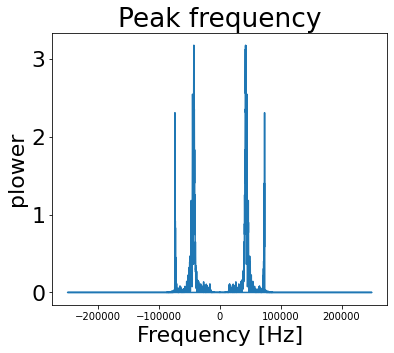

In [ ]:
# The FFT of the signal
sig_fft = fftpack.fft(sig)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)**2

# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 15000)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
#axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])

# scipy.signal.find_peaks_cwt can also be used for more advanced
# peak detection

In [ ]:
 S_left = librosa.stft(sound1, center=False)
librosa.get_duration(S=S_left, sr=sr)

0.003072

In [ ]:
print(sr)

500000


In [ ]:
def write_excel_document1(features,columna,fila,name):
  columnas =['S','T','U','V','W','X','Y','Z',
          'AA','AB','AC','AD','AE','AF','AG','AH','AI','AJ','AK','AL','AM','AN','AO','AP','AQ','AR','AS','AT','AU','AV','AW','AX','AY','AZ',
          'BA','BB','BC','BD','BE','BF','BG','BH','BI','BJ','BK','BL','BM','BN','BO','BP','BQ','BR','BS','BT','BU','BV','BW','BX','BY','BZ',
          'CA','CB','CC','CD','CE','CF','CG','CH','CI','CJ','CK','CL','CM','CN','CO','CP','CQ','CR','CS','CT','CU','CV','CW','CX','CY','CZ',
          'DA','DB','DC','DD','DE','DF','DG','DH','DI','DJ','DK','DL','DM','DN','DO','DP','DQ','DR','DS','DT','DU','DV','DW','DX','DY','DZ',
          'EA','EB','EC','ED','EE','EF','EG','EH','EI','EJ','EK','EL','EM','EN','EO','EP','EQ','ER','ES','ET','EU','EV','EW','EX','EY','EZ',
          'FA','FB','FC','FD','FE','FF','FG','FH','FI','FJ','FK','FL','FM','FN','FO','FP','FQ','FR','FS','FT','FU','FV','FW','FX','FY','FZ',
          'GA','GB','GC','GD','GE','GF','GG','GH','GI','GJ','GK','GL','GM','GN','GO','GP','GQ','GR','GS','GT','GU','GV','GW','GX','GY','GZ',
          'HA','HB','HC','HD','HE','HF','HG','HH','HI','HJ','HK','HL','HM','HN','HO','HP','HQ','HR','HS','HT','HU','HV','HW','HX','HY','HZ',
          'IA','IB','IC','ID','IE','IF','IG','IH','II','IJ','IK','IL','IM','IN','IO','IP','IQ','IR','IS','IT','IU','IV','IW','IX','IY','IZ',
          'JA','JB','JC','JD','JE','JF','JG','JH','JI','JJ','JK','JL','JM','JN','JO','JP','JQ','JR','JS','JT','JU','JV','JW','JX','JY','JZ',
          'KA','KB','KC','KD','KE','KF','KG','KH','KI','KJ','KK','KL','KM','KN','KO','KP','KQ','KR','KS','KT','KU','KV','KW','KX','KY','KZ',
          'LA','LB','LC','LD','LE','LF','LG','LH','LI','LJ','LK','LL','LM','LN','LO','LP','LQ','LR','LS','LT','LU','LV','LW','LX','LY','LZ',
          'MA','MB','MC','MD','ME','MF','MG','MH','MI','MJ','MK','ML','MM','MN','MO','MP','MQ','MR','MS','MT','MU','MV','MW','MX','MY','MZ',
          'NA','NB','NC','ND','NE','NF','NG','NH','NI','NJ','NK','NL','NM','NN','NO','NP','NQ','NR','NS','NT','NU','NV','NW','NX','NY','NZ',
          'OA','OB','OC','OD','OE','OF','OG','OH','OI','OJ','OK','OL','OM','ON','OO','OP','OQ','OR','OS','OT','OU','OV','OW','OX','OY','OZ',
          'PA','PB','PC','PD','PE','PF','PG','PH','PI','PJ','PK','PL','PM','PN','PO','PP','PQ','PR','PS','PT','PU','PV','PW','PX','PY','PZ',
          'QA','QB','QC','QD','QE','QF','QG','QH','QI','QJ','QK','QL','QM','QN','QO','QP','QQ','QR','QS','QT','QU','QV','QW','QX','QY','QZ',
          'RA','RB','RC','RD','RE','RF','RG','RH','RI','RJ','RK','RL','RM','RN','RO','RP','RQ','RR','RS','RT','RU','RV','RW','RX','RY','RZ',
          'SA','SB','SC','SD','SE','SF','SG','SH','SI','SJ','SK','SL','SM','SN','SO','SP','SQ','SR','SS','ST','SU','SV','SW','SX','SY','SZ',
          'TA','TB','TC','TD','TE','TF','TG','TH','TI','TJ','TK','TL','TM','TN','TO','TP','TQ','TR','TS','TT','TU','TV','TW','TX','TY','TZ',
          'UA','UB','UC','UD','UE','UF','UG','UH','UI','UJ','UK','UL','UM','UN','UO','UP','UQ','UR','US','UT','UU','UV','UW','UX','UY','UZ',
          'VA','VB','VC','VD','VE','VF','VG','VH','VI','VJ','VK','VL','VM','VN','VO','VP','VQ','VR','VS','VT','VU','VV','VW','VX','VY','VZ',
          'WA','WB','WC','WD','WE','WF','WG','WH','WI','WJ','WK','WL','WM','WN','WO','WP','WQ','WR','WS','WT','WU','WV','WW','WX','WY','WZ',
          'XA','XB','XC','XD','XE','XF','XG','XH','XI','XJ','XK','XL','XM','XN','XO','XP','XQ','XR','XS','XT','XU','XV','XW','XX','XY','XZ',
          'YA','YB','YC','YD','YE','YF','YG','YH','YI','YJ','YK','YL','YM','YN','YO','YP','YQ','YR','YS','YT','YU','YV','YW','YX','YY','YZ',
          'ZA','ZB','ZC','ZD','ZE','ZF','ZG','ZH','ZI','ZJ','ZK','ZL','ZM','ZN','ZO','ZP','ZQ','ZR','ZS','ZT','ZU','ZV','ZW','ZX','ZY','ZZ',
          'AAA','AAB','AAC','AAD','AAE','AAF','AAG','AAH','AAI','AAJ','AAK','AAL','AAM','AAN','AAO','AAP','AAQ','AAR','AAS','AAT','AAU','AAV','AAW','AAX','AAY','AAZ',
          'ABA','ABB','ABC','ABD','ABE','ABF','ABG','ABH','ABI','ABJ','ABK','ABL','ABM','ABN','ABO','ABP','ABQ','ABR','ABS','ABT','ABU','ABV','ABW','ABX','ABY','ABZ',
          'ACA','ACB','ACC','ACD','ACE','ACF','ACG','ACH','ACI','ACJ','ACK','ACL','ACM','ACN','ACO','ACP','ACQ','ACR','ACS','ACT','ACU','ACV','ACW','ACX','ACY','ACZ',
          'ADA','ADB','ADC','ADD','ADE','ADF','ADG','ADH','ADI','ADJ','ADK','ADL','ADM','ADN','ADO','ADP','ADQ','ADR','ADS','ADT','ADU','ADV','ADW','ADX','ADY','ADZ',
          'AEA','AEB','AEC','AED','AEE','AEF','AEG','AEH','AEI','AEJ','AEK','AEL','AEM','AEN','AEO','AEP','AEQ','AER','AES','AET','AEU','AEV','AEW','AEX','AEY','AEZ',
          'AFA','AFB','AFC','AFD','AFE','AFF','AFG','AFH','AFI','AFJ','AFK','AFL','AFM','AFN','AFO','AFP','AFQ','AFR','AFS','AFT','AFU','AFV','AFW','AFX','AFY','AFZ',
          'AGA','AGB','AGC','AGD','AGE','AGF','AGG','AGH','AGI','AGJ','AGK','AGL','AGM','AGN','AGO','AGP','AGQ','AGR','AGS','AGT','AGU','AGV','AGW','AGX','AGY','AGZ',
          'AHA','AHB','AHC','AHD','AHE','AHF','AHG','AHH','AHI','AHJ','AHK','AHL','AHM','AHN','AHO','AHP','AHQ','AHR','AHS','AHT','AHU','AHV','AHW','AHX','AHY','AHZ',
          'AIA','AIB','AIC','AID','AIE','AIF','AIG','AIH','AII','AIJ','AIK','AIL','AIM','AIN','AIO','AIP','AIQ','AIR','AIS','AIT','AIU','AIV','AIW','AIX','AIY','AIZ',
          'AJA','AJB','AJC','AJD','AJE','AJF','AJG','AJH','AJI','AJJ','AJK','AJL','AJM','AJN','AJO','AJP','AJQ','AJR','AJS','AJT','AJU','AJV','AJW','AJX','AJY','AJZ',
          'AKA','AKB','AKC','AKD','AKE','AKF','AKG','AKH','AKI','AKJ','AKK','AKL','AKM','AKN','AKO','AKP','AKQ','AKR','AKS','AKT','AKU','AKV','AKW','AKX','AKY','AKZ',
          'ALA','ALB','ALC','ALD','ALE','ALF','ALG','ALH','ALI','ALJ','ALK','ALL','ALM','ALN','ALO','ALP','ALQ','ALR','ALS','ALT','ALU','ALV','ALW','ALX','ALY','ALZ',
          'AMA','AMB','AMC','AMD','AME','AMF','AMG','AMH','AMI','AMJ','AMK','AML','AMM','AMN','AMO','AMP','AMQ','AMR','AMS','AMT','AMU','AMV','AMW','AMX','AMY','AMZ',
          'ANA','ANB','ANC','AND','ANE','ANF','ANG','ANH','ANI','ANJ','ANK','ANL','ANM','ANN','ANO','ANP','ANQ','ANR','ANS','ANT','ANU','ANV','ANW','ANX','ANY','ANZ',
          'AOA','AOB','AOC','AOD','AOE','AOF','AOG','AOH','AOI','AOJ','AOK','AOL','AOM','AON','AOO','AOP','AOQ','AOR','AOS','AOT','AOU','AOV','AOW','AOX','AOY','AOZ',
          'APA','APB','APC','APD','APE','APF','APG','APH','API','APJ','APK','APL','APM','APN','APO','APP','APQ','APR','APS','APT','APU','APV','APW','APX','APY','APZ',
          'AQA','AQB','AQC','AQD','AQE','AQF','AQG','AQH','AQI','AQJ','AQK','AQL','AQM','AQN','AQO','AQP','AQQ','AQR','AQS','AQT','AQU','AQV','AQW','AQX','AQY','AQZ',
          'ARA','ARB','ARC','ARD','ARE','ARF','ARG','ARH','ARI','ARJ','ARK','ARL','ARM','ARN','ARO','ARP','ARQ','ARR','ARS','ART','ARU','ARV','ARW','ARX','ARY','ARZ',
          'ASA','ASB','ASC','ASD','ASE','ASF','ASG','ASH','ASI','ASJ','ASK','ASL','ASM','ASN','ASO','ASP','ASQ','ASR','ASS','AST','ASU','ASV','ASW','ASX','ASY','ASZ',
          'ATA','ATB','ATC','ATD','ATE','ATF','ATG','ATH','ATI','ATJ','ATK','ATL','ATM','ATN','ATO','ATP','ATQ','ATR','ATS','ATT','ATU','ATV','ATW','ATX','ATY','ATZ',
          'AUA','AUB','AUC','AUD','AUE','AUF','AUG','AUH','AUI','AUJ','AUK','AUL','AUM','AUN','AUO','AUP','AUQ','AUR','AUS','AUT','AUU','AUV','AUW','AUX','AUY','AUZ',
          'AVA','AVB','AVC','AVD','AVE','AVF','AVG','AVH','AVI','AVJ','AVK','AVL','AVM','AVN','AVO','AVP','AVQ','AVR','AVS','AVT','AVU','AVV','AVW','AVX','AVY','AVZ',
          'AWA','AWB','AWC','AWD','AWE','AWF','AWG','AWH','AWI','AWJ','AWK','AWL','AWM','AWN','AWO','AWP','AWQ','AWR','AWS','AWT','AWU','AWV','AWW','AWX','AWY','AWZ',
          'AXA','AXB','AXC','AXD','AXE','AXF','AXG','AXH','AXI','AXJ','AXK','AXL','AXM','AXN','AXO','AXP','AXQ','AXR','AXS','AXT','AXU','AXV','AXW','AXX','AXY','AXZ',
          'AYA','AYB','AYC','AYD','AYE','AYF','AYG','AYH','AYI','AYJ','AYK','AYL','AYM','AYN','AYO','AYP','AYQ','AYR','AYS','AYT','AYU','AYV','AYW','AYX','AYY','AYZ',
          'AZA','AZB','AZC','AZD','AZE','AZF','AZG','AZH','AZI','AZJ','AZK','AZL','AZM','AZN','AZO','AZP','AZQ','AZR','AZS','AZT','AZU','AZV','AZW','AZX','AZY','AZZ',
          ]
  for feature in features:
    if (fila==3):
      print(name+'_'+str(columna))
    print(feature)
    columna=columna+1
##    print(columna)
  return columna

## Calcular las Caracteristicas

In [ ]:
## Función que procesa los datos extraidos 
import statistics
def extract_values(features):
  z=[]
  z1=[]
  z2=[]
  z3=[]
  z4=[]
  z5=[]
  z6=[]
  fin0=features.shape[0]
  #print(features.shape[1])
  fin=12 # cantidad maxima de frames para los audios
  for x in range(0, fin0):
    try:
      z.append((features[x,:].mean())) # Media por frecuencia para todos los frames
      z1.append((features[x,:].mean())) # Media por frecuencia para todos los frames
      z2.append((statistics.median(features[x,:]))) #  Mediana por frecuencia para todos los frames
      z3.append([features[x,:].mean(),x]) # Orden de de Mayor a menor de las frecuencias por media de potencia
      z4.append(np.argmax(features[x,:])) # Frame de mayor potencia por frecuencia
    except:
      print('Error'+str(x))

  for x in range(0, fin):
    try:
      z5.append(np.argmax(features[:,x]))
      z6.append([features[:,x].mean(),x])
    except:
      z5.append(22) # caundo no hay frames
      z6.append([0,x])# Caundo no tiene dato
      #print('Error 2 '+str(x))
  z.append((np.array(z1).mean()))
  z.append((np.array(z1).max()))
  z.append((np.array(z1).min()))
  ## Se organiza el arreglo para saber cual chroma tiene mayor relevancia
  np4 = sorted(z3, reverse=True, key=lambda a_entry: a_entry[0]) 
  np5=np.asarray(np4, dtype=np.float32)[:,1]
  ## Organizados por importancia  Mayor a menor de las frecuencias por media de potencia para todos los frames
  fin1=np5.shape[0]
  for x1 in range(0, fin1):
    z.append(np5[x1])
  ## Frame de mayor portencia para todas las frecuencias
  for x4 in range(0, len(z4)):
    z.append(z4[x4])

  ## Mediana de los datos
  for x2 in range(0, len(z2)):
    z.append(z2[x2])

  ## Se organiza el arreglo para saber cual chroma tiene mayor relevancia
  np6 = sorted(z6, reverse=True, key=lambda a_entry: a_entry[0]) 
  np7=np.asarray(np6, dtype=np.float32)[:,1]
  ## Organizados por importancia
  fin1=np7.shape[0]
  #print(fin1)
  for x1 in range(0, fin1):
    z.append(np7[x1])
  ## harmonic_mean de los datos
  for x4 in range(0, len(z5)):
    z.append(z5[x4])
  #print(z)
  #print(np5)
  #z.append(z2)
  npa = np.asarray(z, dtype=np.float32)
  #print(npa)
  return npa



In [ ]:
chroma_stft = librosa.feature.chroma_stft(y=sound, sr=sr,n_chroma=12)
      ## Procesa el Chroma
chroma_stft_process=extract_values(chroma_stft)
      ## Escribe en el archivo los datos 
     # columna = write_excel_document (chroma_stft_process,columna,fila,'chroma_stft')
#print(chroma_stft_process)

## Extracción de características 

In [ ]:
## Se define donde estan los nombres de los fragmentos que se van a procesar
import statistics
multiple_cells = sheet['A3':'A833']
## Se recorre las celdas para extraer los nombres 
for row in multiple_cells: 
  for cell in row:

##  Se extrae la información del audio de acuerdo al nombre de la celda, con 
##  esto se garantiza que la información si corresponde a este audio
    try:
      sound = butter_bandpass_filter(batsounds[cell.value],15000,80000,sr,10)
    except:
      print("An exception occurred "+ cell.value)
    
##  Se extrae la fila donde esta el nombre del archivo y se registraran los datos
    fila=cell.row
    columna=0
    if (len (sound) !=0): 
      duracion=librosa.get_duration(y=sound, sr=sr)
      z=[]
      z.append(duracion*1000)
      columna = write_excel_document (z,columna,fila,'Duracion(ms)')

       ## Calculo del TEMPO
      oenv = librosa.onset.onset_strength(y=sound, sr=sr)
      tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)
      # Compute global onset autocorrelation
      ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
      ac_global = librosa.util.normalize(ac_global)
      # Estimate the global tempo for display purposes
      tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr)[0]

      z=[]
      z.append(tempo)
      columna = write_excel_document (z,columna,fila,'TEMPO')

      ## Extraccion de FFT MAX
      # The FFT of the signal
      time_step=1/sr
      period=1
      sig_fft = fftpack.fft(sound)
      # And the power (sig_fft is of complex dtype)
      power = np.abs(sig_fft)
      # The corresponding frequencies
      sample_freq = fftpack.fftfreq(sound.size, d=time_step)
      # Find the peak frequency: we can focus on only the positive frequencies
      pos_mask = np.where(sample_freq >0)
      freqs = sample_freq[pos_mask]
      try:
         peak_freq = freqs[power[pos_mask].argmax()]
      except:
        print("An exception occurred "+ cell.value)
      z=[]
      z.append(peak_freq)
      columna = write_excel_document (z,columna,fila,'FFT_freq_1')

      ## Extraccion de FFT 2
      pos_mask1 = np.where(sample_freq >peak_freq)
      freqs1 = sample_freq[pos_mask1]
      peak_freq1 = freqs1[power[pos_mask1].argmax()]
      z=[]
      z.append(peak_freq1)
      columna = write_excel_document (z,columna,fila,'FFT_freq_2')


      ## Extraccion de FFT 3
      pos_mask2 = np.where(sample_freq >peak_freq1)
      freqs2 = sample_freq[pos_mask2]
      peak_freq2 = freqs2[power[pos_mask2].argmax()]
      z=[]
      z.append(peak_freq2)
      columna = write_excel_document (z,columna,fila,'FFT_freq_3')

      ## Extraccion de FFT 4
      pos_mask3 = np.where(sample_freq >peak_freq2)
      freqs3 = sample_freq[pos_mask3]
      peak_freq3 = freqs3[power[pos_mask3].argmax()]
      z=[]
      z.append(peak_freq3)
      columna = write_excel_document (z,columna,fila,'FFT_freq_4')

      ## Calculo de rolloff 0.8
      rolloff = librosa.feature.spectral_rolloff(y=sound, sr=sr, roll_percent=0.8)
      z=[]
      z1=[]
      z.append(rolloff.max())
      z.append(rolloff.min())
      z.append(rolloff.mean())
      npa = np.asarray(z, dtype=np.float32)
      columna = write_excel_document (npa,columna,fila,'Rolloff_0.8')

      ## Calculo de rolloff 0.5
      rolloff = librosa.feature.spectral_rolloff(y=sound, sr=sr, roll_percent=0.5)
      z=[]
      z1=[]
      z.append(rolloff.max())
      z.append(rolloff.min())
      z.append(rolloff.mean())
      npa = np.asarray(z, dtype=np.float32)
      columna = write_excel_document (npa,columna,fila,'Rolloff_0.5')

      ## Extraccion de Chroma
      chroma_stft = librosa.feature.chroma_stft(y=sound, sr=sr,n_chroma=12)
      ## Procesa el Chroma
      chroma_stft_process=extract_values(chroma_stft)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (chroma_stft_process,columna,fila,'chroma_stft')

      ## Calculo de Chorma CTQ
      chroma_cqt = librosa.feature.chroma_cqt(y=sound, sr=sr)
      ## Procesa el Chroma
      chroma_cqt_process=extract_values(chroma_cqt)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (chroma_cqt_process,columna,fila,'chroma_cqt')

      ## Calculo de Chorma CENS
      chroma_cens = librosa.feature.chroma_cens(y=sound, sr=sr)
      ## Procesa el Chroma
      chroma_cens_process=extract_values(chroma_cens)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (chroma_cens_process,columna,fila,'chroma_CENS')
      
      ## Extraccion de Mell
      bat_mels_features = librosa.feature.melspectrogram(sound, sr=sr,n_mels=10, fmin=15000, fmax=80000)
      ## Procesa el Chroma
      bat_mels_features_process=extract_values(bat_mels_features)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (bat_mels_features_process,columna,fila,'mels')

      ## Extraccion de MFCC
      bat_mfcc_features = librosa.feature.mfcc(sound, sr=sr, n_mfcc=10)
      ## Procesa el Chroma
      bat_mfcc_features_process=extract_values(bat_mfcc_features)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (bat_mfcc_features_process,columna,fila,'MFCC')

      bat_delta_mfcc  = librosa.feature.delta(bat_mfcc_features,mode='nearest')
      ## Procesa el Chroma
      bat_delta_mfcc_process=extract_values(bat_delta_mfcc)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (bat_delta_mfcc_process,columna,fila,'delta_mfcc')

      bat_delta2_mfcc = librosa.feature.delta(bat_mfcc_features,mode='nearest', order=2)
      ## Procesa el Chroma
      bat_delta2_mfcc_process=extract_values(bat_delta2_mfcc)
      ## Escribe en el archivo los datos
      columna = write_excel_document (bat_delta2_mfcc_process,columna,fila,'delta2_mfcc')
      columna_ant=columna
      
      ## Extraccion de expectral centroid
      bat_spectral_centroid_features = librosa.feature.spectral_centroid(y=sound, sr=sr)
      ## Escribe en el archivo los datos 
      columna = write_excel_document ([bat_spectral_centroid_features[0].mean()],columna,fila,'Expectral_Centroid')

      ## Extracción de spectral_bandwidth
      bat_spectral_bandwidth_features = librosa.feature.spectral_bandwidth(y=sound, sr=sr)
      ## Escribe en el archivo los datos 
      columna = write_excel_document ([bat_spectral_bandwidth_features[0].mean()],columna,fila,'spectral_bandwidth')

      ## Extracción de spectral_bandwidth
      if_gram, D = librosa.ifgram(sound)
      bat_spectral_bandwidth_features = librosa.feature.spectral_bandwidth(S=np.abs(D), freq=if_gram)
      ## Escribe en el archivo los datos 
      columna = write_excel_document ([bat_spectral_bandwidth_features[0].mean()],columna,fila,'spectral_bandwidth_center_frequencies')
      
      ## Calculo de zero_crossing_rate
      zero_crossing_rate=librosa.feature.zero_crossing_rate(sound)
      columna = write_excel_document ([zero_crossing_rate[0].mean()],columna,fila,'zero_crossing_rate')

excel_document.save(excel_path)      

 

An exception occurred 2_M500_20180213_182812_239978_239987.wav


NameError: ignored

In [ ]:
## Se define donde estan los nombres de los fragmentos que se van a procesar
multiple_cells_nombre = sheet['A834':'A4427']
## Se recorre las celdas para extraer los nombres 
a=0
for row in multiple_cells_nombre: 
  a=a+1
  for cell in row:

##  Se extrae la información del audio de acuerdo al nombre de la celda, con 
##  esto se garantiza que la información si corresponde a este audio
    try:
      sound = butter_bandpass_filter(batsounds_ruido[cell.value],15000,80000,sr,10)
    except:
      print("An exception occurred "+ cell.value)
    
##  Se extrae la fila donde esta el nombre del archivo y se registraran los datos
    fila=cell.row
    columna=0
    if (len (sound) !=0): 
      duracion=librosa.get_duration(y=sound, sr=sr)
      z=[]
      z.append(duracion*1000)
      columna = write_excel_document (z,columna,fila,'Duracion(ms)')

       ## Calculo del TEMPO
      oenv = librosa.onset.onset_strength(y=sound, sr=sr)
      tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)
      # Compute global onset autocorrelation
      ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
      ac_global = librosa.util.normalize(ac_global)
      # Estimate the global tempo for display purposes
      tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr)[0]

      z=[]
      z.append(tempo)
      columna = write_excel_document (z,columna,fila,'TEMPO')

      ## Extraccion de FFT MAX
      # The FFT of the signal
      time_step=1/sr
      period=1
      sig_fft = fftpack.fft(sound)
      # And the power (sig_fft is of complex dtype)
      power = np.abs(sig_fft)
      # The corresponding frequencies
      sample_freq = fftpack.fftfreq(sound.size, d=time_step)
      # Find the peak frequency: we can focus on only the positive frequencies
      pos_mask = np.where(sample_freq >0)
      freqs = sample_freq[pos_mask]
      try:
         peak_freq = freqs[power[pos_mask].argmax()]
      except:
        print("An exception occurred "+ cell.value)
      z=[]
      z.append(peak_freq)
      columna = write_excel_document (z,columna,fila,'FFT_freq_1')

      ## Extraccion de FFT 2
      pos_mask1 = np.where(sample_freq >peak_freq)
      freqs1 = sample_freq[pos_mask1]
      peak_freq1 = freqs1[power[pos_mask1].argmax()]
      z=[]
      z.append(peak_freq1)
      columna = write_excel_document (z,columna,fila,'FFT_freq_2')


      ## Extraccion de FFT 3
      pos_mask2 = np.where(sample_freq >peak_freq1)
      freqs2 = sample_freq[pos_mask2]
      peak_freq2 = freqs2[power[pos_mask2].argmax()]
      z=[]
      z.append(peak_freq2)
      columna = write_excel_document (z,columna,fila,'FFT_freq_3')

      ## Extraccion de FFT 4
      pos_mask3 = np.where(sample_freq >peak_freq2)
      freqs3 = sample_freq[pos_mask3]
      peak_freq3 = freqs3[power[pos_mask3].argmax()]
      z=[]
      z.append(peak_freq3)
      columna = write_excel_document (z,columna,fila,'FFT_freq_4')

      ## Calculo de rolloff 0.8
      rolloff = librosa.feature.spectral_rolloff(y=sound, sr=sr, roll_percent=0.8)
      z=[]
      z1=[]
      z.append(rolloff.max())
      z.append(rolloff.min())
      z.append(rolloff.mean())
      npa = np.asarray(z, dtype=np.float32)
      columna = write_excel_document (npa,columna,fila,'Rolloff_0.8')

      ## Calculo de rolloff 0.5
      rolloff = librosa.feature.spectral_rolloff(y=sound, sr=sr, roll_percent=0.5)
      z=[]
      z1=[]
      z.append(rolloff.max())
      z.append(rolloff.min())
      z.append(rolloff.mean())
      npa = np.asarray(z, dtype=np.float32)
      columna = write_excel_document (npa,columna,fila,'Rolloff_0.5')

      ## Extraccion de Chroma
      chroma_stft = librosa.feature.chroma_stft(y=sound, sr=sr,n_chroma=12)
      ## Procesa el Chroma
      chroma_stft_process=extract_values(chroma_stft)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (chroma_stft_process,columna,fila,'chroma_stft')

      ## Calculo de Chorma CTQ
      chroma_cqt = librosa.feature.chroma_cqt(y=sound, sr=sr)
      ## Procesa el Chroma
      chroma_cqt_process=extract_values(chroma_cqt)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (chroma_cqt_process,columna,fila,'chroma_cqt')

      ## Calculo de Chorma CENS
      chroma_cens = librosa.feature.chroma_cens(y=sound, sr=sr)
      ## Procesa el Chroma
      chroma_cens_process=extract_values(chroma_cens)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (chroma_cens_process,columna,fila,'chroma_CENS')
      
      ## Extraccion de Mell
      bat_mels_features = librosa.feature.melspectrogram(sound, sr=sr,n_mels=10, fmin=15000, fmax=80000)
      ## Procesa el Chroma
      bat_mels_features_process=extract_values(bat_mels_features)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (bat_mels_features_process,columna,fila,'mels')

      ## Extraccion de MFCC
      bat_mfcc_features = librosa.feature.mfcc(sound, sr=sr, n_mfcc=10)
      ## Procesa el Chroma
      bat_mfcc_features_process=extract_values(bat_mfcc_features)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (bat_mfcc_features_process,columna,fila,'MFCC')

      bat_delta_mfcc  = librosa.feature.delta(bat_mfcc_features,mode='nearest')
      ## Procesa el Chroma
      bat_delta_mfcc_process=extract_values(bat_delta_mfcc)
      ## Escribe en el archivo los datos 
      columna = write_excel_document (bat_delta_mfcc_process,columna,fila,'delta_mfcc')

      bat_delta2_mfcc = librosa.feature.delta(bat_mfcc_features,mode='nearest', order=2)
      ## Procesa el Chroma
      bat_delta2_mfcc_process=extract_values(bat_delta2_mfcc)
      ## Escribe en el archivo los datos
      columna = write_excel_document (bat_delta2_mfcc_process,columna,fila,'delta2_mfcc')
      columna_ant=columna
      
      ## Extraccion de expectral centroid
      bat_spectral_centroid_features = librosa.feature.spectral_centroid(y=sound, sr=sr)
      ## Escribe en el archivo los datos 
      columna = write_excel_document ([bat_spectral_centroid_features[0].mean()],columna,fila,'Expectral_Centroid')

      ## Extracción de spectral_bandwidth
      bat_spectral_bandwidth_features = librosa.feature.spectral_bandwidth(y=sound, sr=sr)
      ## Escribe en el archivo los datos 
      columna = write_excel_document ([bat_spectral_bandwidth_features[0].mean()],columna,fila,'spectral_bandwidth')

      ## Extracción de spectral_bandwidth
      if_gram, D = librosa.ifgram(sound)
      bat_spectral_bandwidth_features = librosa.feature.spectral_bandwidth(S=np.abs(D), freq=if_gram)
      ## Escribe en el archivo los datos 
      columna = write_excel_document ([bat_spectral_bandwidth_features[0].mean()],columna,fila,'spectral_bandwidth_center_frequencies')
      
      ## Calculo de zero_crossing_rate
      zero_crossing_rate=librosa.feature.zero_crossing_rate(sound)
      columna = write_excel_document ([zero_crossing_rate[0].mean()],columna,fila,'zero_crossing_rate')
      
      if (modulo(a,1000) ==0): 
        excel_document.save(excel_path)

excel_document.save(excel_path)     

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/lib/python3.6/dist-packages/librosa/beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


An exception occurred 66_M500_20190606_183124_6165_6120.wav
An exception occurred 149_M500_20190606_183124_25293_25235.wav
An exception occurred 181_M500_20190606_183124_30478_30459.wav
An exception occurred 227_M500_20190606_183124_31998_31009.wav
An exception occurred 332_M500_20190606_183124_37773_37740.wav
An exception occurred 543_M500_20190606_183124_50065_50065.wav
An exception occurred 607_M500_20190606_183124_51241_50244.wav
An exception occurred 869_M500_20190606_183124_61882_61878.wav
An exception occurred 1600_M500_20190606_183124_123244_123161.wav
An exception occurred 3283_M500_20190606_183124_259877_250891.wav
An exception occurred 3462_M500_20190606_183124_281604_280614.wav
An exception occurred 3523_M500_20190606_183124_291591_291512.wav


## Lectura de caracteristicas extraidas para procesar

In [ ]:
## Definición de las columnas con la información de las caracteristicas
## Se crea la matriz de datos con las caracteristicas
cantidad_datos_null=0
data = []
features_fordes = []
fila_inicio='2'
fila_nombres='1'
columna_inicio='K'
columna_inicio_aut='S'
fila_fin='4405'
columna_fin='WL'
celda_inicio=columna_inicio+fila_inicio
celda_fin=columna_fin+fila_fin
celda_inicio_aut=columna_inicio_aut+fila_inicio
#multiple_cells = sheet['K3':'NN833']
multiple_cells = sheet[celda_inicio:celda_fin]
for row in multiple_cells: 
  fila = []
  feature_fila = []
  for cell in row:
     try:
      ## Se extraen los datos y se calcula el abs para poder emplear scatter_matrix
      fila.append(abs(cell.value))
      ## Se extraen los datos sin modificar para los calculos estadisticos
      feature_fila.append(cell.value)
     except:
     ##  print("An exception occurred ")
       if (cell.value ==None):
          fila.append((0))
          feature_fila.append(0)
       else:
          fila.append(0)
          print(cell.coordinate)
          print(cell.value)
          feature_fila.append(0)
       cantidad_datos_null=cantidad_datos_null+1

  data.append (fila) 
  features_fordes.append (feature_fila) 
datos=np.array(data)
features_fd1=np.array(features_fordes)

print(datos.shape)
print(features_fd1.shape)


## Se crea una matriz con los datos calculados de manera automática
cantidad_datos_null=0
data_aut = []
features_aut = []
multiple_cells = sheet[celda_inicio_aut:celda_fin]
for row in multiple_cells: 
  fila = []
  feature_fila = []
  for cell in row:
     try:
      ## Se extraen los datos y se calcula el abs para poder emplear scatter_matrix
      fila.append(abs(cell.value))
      ## Se extraen los datos sin modificar para los calculos estadisticos
      feature_fila.append(cell.value)
     except:
     ##  print("An exception occurred ")
       if (cell.value ==None):
          fila.append((0))
          feature_fila.append(0)
       else:
          fila.append(0)
          print(cell.coordinate)
          print(cell.value)
          feature_fila.append(0)
       cantidad_datos_null=cantidad_datos_null+1

  data_aut.append (fila) 
  features_aut.append (feature_fila) 
datos_aut=np.array(data_aut)
features_fd1_aut=np.array(features_aut)

print(datos_aut.shape)
print(features_fd1_aut.shape)

## se extrae el nombre de las acaracteristicas automáticas
multiple_cells_names = sheet[columna_inicio_aut+fila_nombres:columna_fin+fila_nombres]
feature_names_aut = []
for row in multiple_cells_names: 
  for cell in row:
    feature_names_aut.append(cell.value)
print(feature_names_aut)

## se extrae el nombre de las acaracteristicas
multiple_cells_names = sheet[columna_inicio+fila_nombres:columna_fin+fila_nombres]
feature_names = []
for row in multiple_cells_names: 
  for cell in row:
    feature_names.append(cell.value)
print(feature_names)


## se extrae la etiqueta de los datos para los tipos de pulso [CF-FM, QCF, FM]
multiple_cells = sheet['F'+fila_inicio:'F'+fila_fin]
target = []
for row in multiple_cells: 
  for cell in row:
    
    try:
      target.append((cell.value))
    except:
      print(row)
      print(cell.value)
print(target)
pulso_name=np.array(target)

## se extrae la etiqueta de los datos para los tipos de pulso [CF-FM, QCF, FM]
multiple_cells = sheet['G'+fila_inicio:'G'+fila_fin]
target = []
for row in multiple_cells: 
  for cell in row:
    
    try:
      target.append(int(cell.value))
    except:
      print(row)
      print(cell.value)
print(target)
target1=np.array(target)

## se extrae la etiqueta de los datos para las fases [BÚSQUEDA, ENFOQUE,TERMINAL]
multiple_cells = sheet['I'+fila_inicio:'I'+fila_fin]
target_fases = []
for row in multiple_cells: 
  for cell in row:
    target_fases.append(cell.value)
print(target_fases)
target_fase1=np.array(target_fases)

## se extrae la etiqueta de los datos para las fases [BÚSQUEDA, ENFOQUE,TERMINAL]
multiple_cells = sheet['H'+fila_inicio:'H'+fila_fin]
target_fases = []
for row in multiple_cells: 
  for cell in row:
    target_fases.append(cell.value)
print(target_fases)
fase_name=np.array(target_fases)


## se extrae la etiqueta de los datos para las fases [RUIDO SIN RUIDO]
multiple_cells = sheet['J'+fila_inicio:'J'+fila_fin]
target_entorno = []
for row in multiple_cells: 
  for cell in row:
    target_entorno.append(cell.value)
print(target_entorno)
target_entorno=np.array(target_entorno)
print(cantidad_datos_null)

(4404, 600)
(4404, 600)
(4404, 592)
(4404, 592)
['Duracion_(ms)', 'TEMPO', 'FFT_freq_1', 'FFT_freq_2', 'FFT_freq_3', 'FFT_freq_4', 'Rolloff_0.8_max', 'Rolloff_0.8_min', 'Rolloff_0.8_avg', 'Rolloff_0.5_max', 'Rolloff_0.5_min', 'Rolloff_0.5_avg', 'chroma_stft_avg(y1)', 'chroma_stft_avg(y2)', 'chroma_stft_avg(y3)', 'chroma_stft_avg(y4)', 'chroma_stft_avg(y5)', 'chroma_stft_avg(y6)', 'chroma_stft_avg(y7)', 'chroma_stft_avg(y8)', 'chroma_stft_avg(y9)', 'chroma_stft_avg(y10)', 'chroma_stft_avg(y11)', 'chroma_stft_avg(y12)', 'chroma_stft_avg(avg(y1):avg(y12))', 'chroma_stft_max(avg(y1):avg(y12))', 'chroma_stft_min(avg(y1):avg(y12))', 'chroma_stft_order_by(avg(y1):avg(y12))desc(1)', 'chroma_stft_order_by(avg(y1):avg(y12))desc(2)', 'chroma_stft_order_by(avg(y1):avg(y12))desc(3)', 'chroma_stft_order_by(avg(y1):avg(y12))desc(4)', 'chroma_stft_order_by(avg(y1):avg(y12))desc(5)', 'chroma_stft_order_by(avg(y1):avg(y12))desc(6)', 'chroma_stft_order_by(avg(y1):avg(y12))desc(7)', 'chroma_stft_order_by(

In [ ]:
print(np.array(target_entorno).shape)

(4404,)


In [ ]:
fase_name

array(['BÚSQUEDA', 'BÚSQUEDA', 'BÚSQUEDA', ..., 'BÚSQUEDA', 'BÚSQUEDA',
       'BÚSQUEDA'], dtype='<U8')

### Podemos inspeccionar de forma manual las características del último elemento del conjunto de datos:

In [ ]:
print(list(zip(feature_names_aut, features_aut[4000])))

[('Duracion_(ms)', 11), ('TEMPO', 135.3204387990762), ('FFT_freq_1', 72818.18181818182), ('FFT_freq_2', 73090.9090909091), ('FFT_freq_3', 73272.72727272728), ('FFT_freq_4', 73363.63636363637), ('Rolloff_0.8_max', 70068.359375), ('Rolloff_0.8_min', 45166.015625), ('Rolloff_0.8_avg', 59770.0625), ('Rolloff_0.5_max', 57617.1875), ('Rolloff_0.5_min', 34912.109375), ('Rolloff_0.5_avg', 42857.77734375), ('chroma_stft_avg(y1)', 0.7619901895523071), ('chroma_stft_avg(y2)', 0.6572156548500061), ('chroma_stft_avg(y3)', 0.3732095062732697), ('chroma_stft_avg(y4)', 0.2308402806520462), ('chroma_stft_avg(y5)', 0.3645562529563904), ('chroma_stft_avg(y6)', 0.2928193211555481), ('chroma_stft_avg(y7)', 0.3311578035354614), ('chroma_stft_avg(y8)', 0.2655194401741028), ('chroma_stft_avg(y9)', 0.2720841765403748), ('chroma_stft_avg(y10)', 0.4027269184589386), ('chroma_stft_avg(y11)', 0.5361444354057312), ('chroma_stft_avg(y12)', 0.5802668929100037), ('chroma_stft_avg(avg(y1):avg(y12))', 0.4223775863647461

Normalizacion de los datos

Visualización usando Pandas Para las Etiquetas de Tipo de Pulso (FM QCF CF-FM) La función boxplot de Pandas nos permite visualizar cada elemento del conjunto de datos como una comparación entre características:

A continuación comparamos cada pareja de características usando boxplot:

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
df2 = pd.DataFrame(features_fordes, columns=feature_names)
scaler = MinMaxScaler()
scaled_data_tipo_pulso1 = scaler.fit_transform(df2)
scaled_data_tipo_pulso1 = pd.DataFrame(scaled_data_tipo_pulso1, columns=feature_names)
scaled_data_tipo_pulso1['Pulso'] = pd.Series(target1)
#boxplot = scaled_data_tipo_pulso1.boxplot(by='Pulso', figsize=(80, 80))

df1 = pd.DataFrame(features_aut, columns=feature_names_aut)
scaler = MinMaxScaler()
scaled_data_tipo_pulso_aut = scaler.fit_transform(df1)
scaled_data_tipo_pulso_aut = pd.DataFrame(scaled_data_tipo_pulso_aut, columns=feature_names_aut)
scaled_data_tipo_pulso_aut_target = pd.DataFrame(scaled_data_tipo_pulso_aut, columns=feature_names_aut)
scaled_data_tipo_pulso_aut_target['Pulso'] = pd.Series(target1)


In [ ]:
df2['chroma_CENS_277'].describe()

count    4397.000000
mean       10.325904
std         9.003411
min         0.000000
25%         2.000000
50%         7.000000
75%        22.000000
max        22.000000
Name: chroma_CENS_277, dtype: float64

In [ ]:
scaled_data_tipo_pulso1['mels_333'].shape

(4397,)

In [ ]:
#boxplot = scaled_data_tipo_pulso1.boxplot(by='Pulso', figsize=(80, 80))

'chroma_stft_12', 'chroma_stft_13', 'chroma_stft_14', 'chroma_stft_15', 'chroma_stft_16', 'chroma_stft_17', 'chroma_stft_18', 'chroma_stft_19', 'chroma_stft_20', 'chroma_stft_21', 'chroma_stft_22', 'chroma_stft_23', 'chroma_stft_24', 'chroma_stft_25', 'chroma_stft_26', 'chroma_stft_27', 'chroma_stft_28', 'chroma_stft_29', 'chroma_stft_30', 'chroma_stft_31', 'chroma_stft_32', 'chroma_stft_33', 'chroma_stft_34', 'chroma_stft_35', 'chroma_stft_36', 'chroma_stft_37', 'chroma_stft_38', 'chroma_stft_39', 'chroma_stft_40', 'chroma_stft_41', 'chroma_stft_42', 'chroma_stft_43', 'chroma_stft_44', 'chroma_stft_45', 'chroma_stft_46', 'chroma_stft_47', 'chroma_stft_48', 'chroma_stft_49', 'chroma_stft_50', 'chroma_stft_51', 'chroma_stft_52', 'chroma_stft_53', 'chroma_stft_54', 'chroma_stft_55', 'chroma_stft_56', 'chroma_stft_57', 'chroma_stft_58', 'chroma_stft_59', 'chroma_stft_60', 'chroma_stft_61', 'chroma_stft_62', 'chroma_stft_63', 'chroma_stft_64', 'chroma_stft_65', 'chroma_stft_66', 'chroma_stft_67', 'chroma_stft_68', 'chroma_stft_69', 'chroma_stft_70', 'chroma_stft_71', 'chroma_stft_72', 'chroma_stft_73', 'chroma_stft_74', 'chroma_stft_75', 'chroma_stft_76', 'chroma_stft_77', 'chroma_stft_78', 'chroma_stft_79', 'chroma_stft_80', 'chroma_stft_81', 'chroma_stft_82', 'chroma_stft_83', 'chroma_stft_84', 'chroma_stft_85', 'chroma_stft_86', 'chroma_stft_87', 'chroma_stft_88', 'chroma_stft_89', 'chroma_stft_90', 'chroma_stft_91', 'chroma_stft_92', 'chroma_stft_93', 'chroma_stft_94', 'chroma_stft_95', 'chroma_stft_96', 'chroma_stft_97'


In [ ]:
#'chroma_stft_12', 'chroma_stft_13', 'chroma_stft_14', 'chroma_stft_15', 'chroma_stft_16', 'chroma_stft_17', 'chroma_stft_18', 'chroma_stft_19', 'chroma_stft_20', 'chroma_stft_21', 'chroma_stft_22', 'chroma_stft_23', 'chroma_stft_24', 'chroma_stft_25', 'chroma_stft_26', 'chroma_stft_27', 'chroma_stft_28', 'chroma_stft_29', 'chroma_stft_30', 'chroma_stft_31', 'chroma_stft_32', 'chroma_stft_33', 'chroma_stft_34', 'chroma_stft_35', 'chroma_stft_36', 'chroma_stft_37', 'chroma_stft_38', 'chroma_stft_39', 'chroma_stft_40', 'chroma_stft_41', 'chroma_stft_42', 'chroma_stft_43', 'chroma_stft_44', 'chroma_stft_45', 'chroma_stft_46', 'chroma_stft_47', 'chroma_stft_48', 'chroma_stft_49', 'chroma_stft_50', 'chroma_stft_51', 'chroma_stft_52', 'chroma_stft_53', 'chroma_stft_54', 'chroma_stft_55', 'chroma_stft_56', 'chroma_stft_57', 'chroma_stft_58', 'chroma_stft_59', 'chroma_stft_60', 'chroma_stft_61', 'chroma_stft_62', 'chroma_stft_63', 'chroma_stft_64', 'chroma_stft_65', 'chroma_stft_66', 'chroma_stft_67', 'chroma_stft_68', 'chroma_stft_69', 'chroma_stft_70', 'chroma_stft_71', 'chroma_stft_72', 'chroma_stft_73', 'chroma_stft_74', 'chroma_stft_75', 'chroma_stft_76', 'chroma_stft_77', 'chroma_stft_78', 'chroma_stft_79', 'chroma_stft_80', 'chroma_stft_81', 'chroma_stft_82', 'chroma_stft_83', 'chroma_stft_84', 'chroma_stft_85', 'chroma_stft_86', 'chroma_stft_87', 'chroma_stft_88', 'chroma_stft_89', 'chroma_stft_90', 'chroma_stft_91', 'chroma_stft_92', 'chroma_stft_93', 'chroma_stft_94', 'chroma_stft_95', 'chroma_stft_96', 'chroma_stft_97'
caracteristicas=['Frecuencia pico (kHz)', 'Frecuencia inicial (kHz)', 'Frecuencia final (kHz)', 'Frecuencia máxima (kHz)', 'Frecuencia mínima (kHz)', 'Ancho de banda (kHz)', 'Duración (ms)', 'Intervalo (ms)']

##Graficas de manuales

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mfcc_order_by(avg(x1):avg(x21))desc(3)


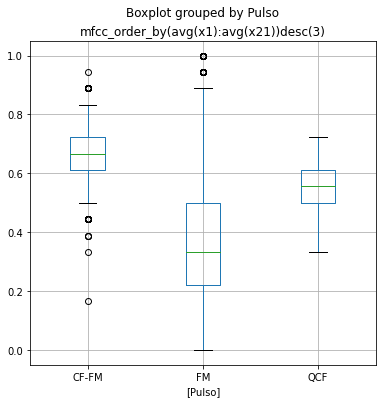

<Figure size 720x4320 with 0 Axes>

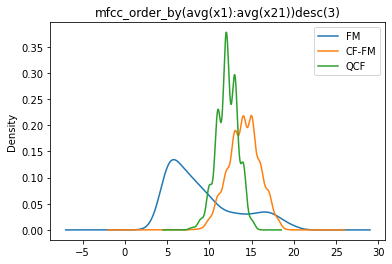

     mfcc_order_by(avg(x1):avg(x21))desc(3)             ...            
                                      count       mean  ...   75%   max
tipo                                                    ...            
1                                    1481.0  14.070898  ...  15.0  19.0
2                                    2411.0   9.136043  ...  11.0  20.0
3                                     512.0  12.111328  ...  13.0  15.0

[3 rows x 8 columns]
mfcc_order_by(avg(x1):avg(x21))desc(3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


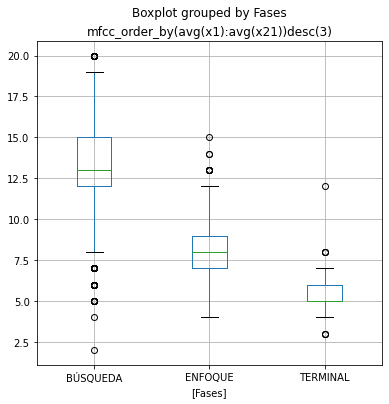

<Figure size 720x4320 with 0 Axes>

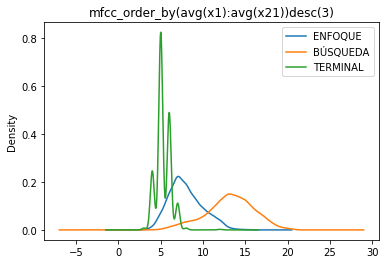

     mfcc_order_by(avg(x1):avg(x21))desc(3)             ...            
                                      count       mean  ...   75%   max
tipo                                                    ...            
1                                    3032.0  13.168206  ...  15.0  20.0
2                                     706.0   7.956091  ...   9.0  15.0
3                                     666.0   5.291291  ...   6.0  12.0

[3 rows x 8 columns]


In [ ]:
caracteristicas1=['Frecuencia pico (kHz)']
caracteristicas2=['Frecuencia inicial (kHz)']
caracteristicas3=[ 'Frecuencia final (kHz)']
caracteristicas4=['Frecuencia máxima (kHz)']
caracteristicas5=['Frecuencia mínima (kHz)']
caracteristicas6=[ 'Ancho de banda (kHz)']
caracteristicas7=['Duración (ms)']
caracteristicas=[ 'mfcc_order_by(avg(x1):avg(x21))desc(3)']
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
df2 = pd.DataFrame(features_fordes, columns=feature_names)
split1=df2[caracteristicas]
scaler = MinMaxScaler()
scaled_data_tipo_pulso1 = scaler.fit_transform(split1)
scaled_data_tipo_pulso1 = pd.DataFrame(scaled_data_tipo_pulso1, columns=caracteristicas)
scaled_data_tipo_pulso1['Pulso'] = pd.Series(pulso_name)
#data_filter = scaled_data_tipo_pulso1[scaled_data_tipo_pulso1['Intervalo (ms)'] <= 0.02]
boxplot = scaled_data_tipo_pulso1.boxplot(by='Pulso', figsize=(6, 6))
#scaled_fase.describe

##columns=[ 'mels_322','Frecuencia mínima (kHz)','Frecuencia final (kHz)','Frecuencia máxima (kHz)','Frecuencia inicial (kHz)','Frecuencia pico (kHz)']

## Pulsos

grupo_1='CF-FM'
grupo_2='FM'
grupo_3='QCF'

## Fases
#grupo_1='BÚSQUEDA'
#grupo_2='ENFOQUE'
#grupo_3='TERMINAL'

pca_data_pulso=df2[caracteristicas]


pca_data_pulso['tipo']=target1
#pca_data_pulso['tipo']=target_fase1
#data_filter = pca_data_pulso[pca_data_pulso['Intervalo (ms)'] <= 100]
columns=caracteristicas



grouped_data_pulso = pca_data_pulso.groupby('tipo',group_keys=True)

fig = plt.figure(figsize=(10, 60))
fig.subplots_adjust(left=0.01, bottom=0.02, top=1.1, right=0.99)
for i, sc in enumerate(columns):
    print(sc)
    datos_pulso={}
    datos_pulso[grupo_1]=np.array(grouped_data_pulso.get_group(1)[sc])
    pd1=pd.DataFrame(datos_pulso)
    datos_pulso={}
    datos_pulso[grupo_2]=np.array(grouped_data_pulso.get_group(2)[sc])
    pd2=pd.DataFrame(datos_pulso)
    datos_pulso={}
    datos_pulso[grupo_3]=np.array(grouped_data_pulso.get_group(3)[sc])
    pd3=pd.DataFrame(datos_pulso)
    pd4=pd.concat([pd2, pd1, pd3], join ='outer', axis=1)
    pd4.plot(kind='kde', title=sc)
plt.show()##


print(grouped_data_pulso.describe ())


scaler = MinMaxScaler()
scaled_data_tipo_pulso1 = scaler.fit_transform(split1)
scaled_data_tipo_pulso1 = pd.DataFrame(split1, columns=caracteristicas)
scaled_data_tipo_pulso1['Fases'] = pd.Series(fase_name)
boxplot = scaled_data_tipo_pulso1.boxplot(by='Fases', figsize=(6, 6))
#scaled_fase.describe

##columns=[ 'mels_322','Frecuencia mínima (kHz)','Frecuencia final (kHz)','Frecuencia máxima (kHz)','Frecuencia inicial (kHz)','Frecuencia pico (kHz)']

## Pulsos


## Fases
grupo_1='BÚSQUEDA'
grupo_2='ENFOQUE'
grupo_3='TERMINAL'

pca_data_pulso=df2[caracteristicas]
#pca_data_pulso['tipo']=target1
pca_data_pulso['tipo']=target_fase1
columns=caracteristicas

grouped_data_pulso = pca_data_pulso.groupby('tipo',group_keys=True)

fig = plt.figure(figsize=(10, 60))
fig.subplots_adjust(left=0.01, bottom=0.02, top=1.1, right=0.99)
for i, sc in enumerate(columns):
    print(sc)
    datos_pulso={}
    datos_pulso[grupo_1]=np.array(grouped_data_pulso.get_group(1)[sc])
    pd1=pd.DataFrame(datos_pulso)
    datos_pulso={}
    datos_pulso[grupo_2]=np.array(grouped_data_pulso.get_group(2)[sc])
    pd2=pd.DataFrame(datos_pulso)
    datos_pulso={}
    datos_pulso[grupo_3]=np.array(grouped_data_pulso.get_group(3)[sc])
    pd3=pd.DataFrame(datos_pulso)
    pd4=pd.concat([pd2, pd1, pd3], join ='outer', axis=1)
    pd4.plot(kind='kde', title=sc)
plt.show()##

print(grouped_data_pulso.describe ())


##Graficas de automaticas


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


delta_mfcc_order_by(avg(x1):avg(x21))desc(1)


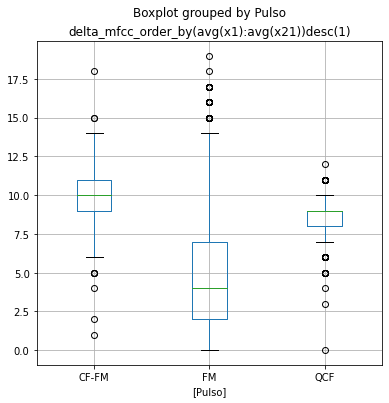

<Figure size 720x4320 with 0 Axes>

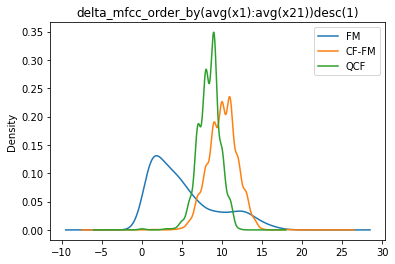

     delta_mfcc_order_by(avg(x1):avg(x21))desc(1)             ...            
                                            count       mean  ...   75%   max
tipo                                                          ...            
1                                          1481.0  10.091155  ...  11.0  18.0
2                                          2411.0   5.220241  ...   7.0  19.0
3                                           512.0   8.400391  ...   9.0  12.0

[3 rows x 8 columns]
delta_mfcc_order_by(avg(x1):avg(x21))desc(1)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


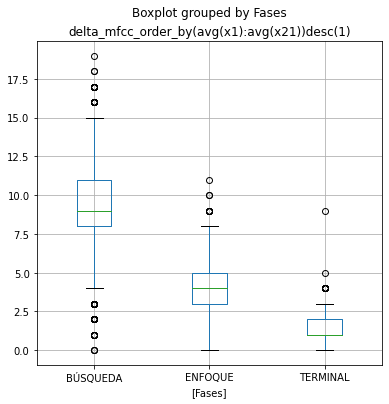

<Figure size 720x4320 with 0 Axes>

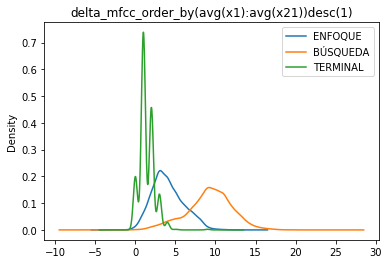

     delta_mfcc_order_by(avg(x1):avg(x21))desc(1)            ...            
                                            count      mean  ...   75%   max
tipo                                                         ...            
1                                          3032.0  9.246372  ...  11.0  19.0
2                                           706.0  4.049575  ...   5.0  11.0
3                                           666.0  1.408408  ...   2.0   9.0

[3 rows x 8 columns]


In [ ]:
caracteristicas1=['mels_max(x)for(y9)']
caracteristicas2=['delta_mfcc_median(y8)']
caracteristicas3=['chroma_stft_avg(y4)']
caracteristicas4=['mfcc_order_by(avg(x1):avg(x21))desc(1)']
caracteristicas=['delta_mfcc_order_by(avg(x1):avg(x21))desc(1)']
caracteristicas6=[ 'delta2_mfcc_order_by(avg(x1):avg(x21))desc(1)']
caracteristicas7=['Duración (ms)']
caracteristicas8=[ 'mfcc_order_by(avg(x1):avg(x21))desc(3)']
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
df2 = pd.DataFrame(features_fordes, columns=feature_names)
split1=df2[caracteristicas]
scaler = MinMaxScaler()
scaled_data_tipo_pulso1 = scaler.fit_transform(split1)
scaled_data_tipo_pulso1 = pd.DataFrame(split1, columns=caracteristicas)
scaled_data_tipo_pulso1['Pulso'] = pd.Series(pulso_name)
#data_filter = scaled_data_tipo_pulso1[scaled_data_tipo_pulso1['Intervalo (ms)'] <= 0.02]
boxplot = scaled_data_tipo_pulso1.boxplot(by='Pulso', figsize=(6, 6))
#scaled_fase.describe

##columns=[ 'mels_322','Frecuencia mínima (kHz)','Frecuencia final (kHz)','Frecuencia máxima (kHz)','Frecuencia inicial (kHz)','Frecuencia pico (kHz)']

## Pulsos

grupo_1='CF-FM'
grupo_2='FM'
grupo_3='QCF'

## Fases
#grupo_1='BÚSQUEDA'
#grupo_2='ENFOQUE'
#grupo_3='TERMINAL'

pca_data_pulso=df2[caracteristicas]


pca_data_pulso['tipo']=target1
#pca_data_pulso['tipo']=target_fase1
#data_filter = pca_data_pulso[pca_data_pulso['Intervalo (ms)'] <= 100]
columns=caracteristicas



grouped_data_pulso = pca_data_pulso.groupby('tipo',group_keys=True)

fig = plt.figure(figsize=(10, 60))
fig.subplots_adjust(left=0.01, bottom=0.02, top=1.1, right=0.99)
for i, sc in enumerate(columns):
    print(sc)
    datos_pulso={}
    datos_pulso[grupo_1]=np.array(grouped_data_pulso.get_group(1)[sc])
    pd1=pd.DataFrame(datos_pulso)
    datos_pulso={}
    datos_pulso[grupo_2]=np.array(grouped_data_pulso.get_group(2)[sc])
    pd2=pd.DataFrame(datos_pulso)
    datos_pulso={}
    datos_pulso[grupo_3]=np.array(grouped_data_pulso.get_group(3)[sc])
    pd3=pd.DataFrame(datos_pulso)
    pd4=pd.concat([pd2, pd1, pd3], join ='outer', axis=1)
    pd4.plot(kind='kde', title=sc)
plt.show()##


print(grouped_data_pulso.describe ())


scaler = MinMaxScaler()
scaled_data_tipo_pulso1 = scaler.fit_transform(split1)
scaled_data_tipo_pulso1 = pd.DataFrame(split1, columns=caracteristicas)
scaled_data_tipo_pulso1['Fases'] = pd.Series(fase_name)
boxplot = scaled_data_tipo_pulso1.boxplot(by='Fases', figsize=(6, 6))
#scaled_fase.describe

##columns=[ 'mels_322','Frecuencia mínima (kHz)','Frecuencia final (kHz)','Frecuencia máxima (kHz)','Frecuencia inicial (kHz)','Frecuencia pico (kHz)']

## Pulsos


## Fases
grupo_1='BÚSQUEDA'
grupo_2='ENFOQUE'
grupo_3='TERMINAL'

pca_data_pulso=df2[caracteristicas]
#pca_data_pulso['tipo']=target1
pca_data_pulso['tipo']=target_fase1
columns=caracteristicas

grouped_data_pulso = pca_data_pulso.groupby('tipo',group_keys=True)

fig = plt.figure(figsize=(10, 60))
fig.subplots_adjust(left=0.01, bottom=0.02, top=1.1, right=0.99)
for i, sc in enumerate(columns):
    print(sc)
    datos_pulso={}
    datos_pulso[grupo_1]=np.array(grouped_data_pulso.get_group(1)[sc])
    pd1=pd.DataFrame(datos_pulso)
    datos_pulso={}
    datos_pulso[grupo_2]=np.array(grouped_data_pulso.get_group(2)[sc])
    pd2=pd.DataFrame(datos_pulso)
    datos_pulso={}
    datos_pulso[grupo_3]=np.array(grouped_data_pulso.get_group(3)[sc])
    pd3=pd.DataFrame(datos_pulso)
    pd4=pd.concat([pd2, pd1, pd3], join ='outer', axis=1)
    pd4.plot(kind='kde', title=sc)
plt.show()##

print(grouped_data_pulso.describe ())

In [ ]:
##print(grouped_data_pulso.quantile (0.25))
Tabla = """\
+--------------------------------------------------------------------------------------------+
|cantidad|media|Desviacion estandar|minimo|25%|50%|75%|maximo|
|--------------------------------------------------------------------------------------------|
{}
+--------------------------------------------------------------------------------------------+\
"""
pca_data_pulso=df2[caracteristicas]
pca_data_pulso['tipo']=target1
#pca_data_pulso['tipo']=target_fase1
columns=caracteristicas
grouped_data_pulso = pca_data_pulso.groupby('tipo',group_keys=True)
ListasAlumnos = np.array(grouped_data_pulso.describe()).tolist()
Tabla = (Tabla.format('\n'.join("{:>1}|{:>1}|{:>1}|{:>1}|{:>1}|{:>1}|{:>1}|{:>1}|".format(*fila) for fila in ListasAlumnos)))
print (Tabla)


Tabla1 = """\
+--------------------------------------------------------------------------------------------+
|cantidad|media|Desviacion estandar|minimo|25%|50%|75%|maximo|
|--------------------------------------------------------------------------------------------|
{}
+--------------------------------------------------------------------------------------------+\
"""
pca_data_pulso1=df2[caracteristicas]
#pca_data_pulso['tipo']=target1
pca_data_pulso1['tipo']=target_fase1
columns=caracteristicas
grouped_data_pulso1 = pca_data_pulso1.groupby('tipo',group_keys=True)
ListasAlumnos1 = np.array(grouped_data_pulso1.describe()).tolist()
Tabla1 = (Tabla1.format('\n'.join("{:>1}|{:>1}|{:>1}|{:>1}|{:>1}|{:>1}|{:>1}|{:>1}|".format(*fila) for fila in ListasAlumnos1)))
print (Tabla1)

+--------------------------------------------------------------------------------------------+
|cantidad|media|Desviacion estandar|minimo|25%|50%|75%|maximo|
|--------------------------------------------------------------------------------------------|
1481.0|10.091154625253207|1.7791385186776503|1.0|9.0|10.0|11.0|18.0|
2411.0|5.220240564081294|4.130046379356027|0.0|2.0|4.0|7.0|19.0|
512.0|8.400390625|1.3569563630360237|0.0|8.0|9.0|9.0|12.0|
+--------------------------------------------------------------------------------------------+
+--------------------------------------------------------------------------------------------+
|cantidad|media|Desviacion estandar|minimo|25%|50%|75%|maximo|
|--------------------------------------------------------------------------------------------|
3032.0|9.246372031662268|2.817380197152069|0.0|8.0|9.0|11.0|19.0|
706.0|4.04957507082153|1.9252944409693058|0.0|3.0|4.0|5.0|11.0|
666.0|1.4084084084084083|0.9378530215841956|0.0|1.0|1.0|2.0|9.0|
+----------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Normalizacion de los datos

Visualización usando Pandas Para las Etiquetas de Tipo de fase [BÚSQUEDA, ENFOQUE,TERMINAL] La función boxplot de Pandas nos permite visualizar cada elemento del conjunto de datos como una comparación entre características:

A continuación comparamos cada pareja de características usando boxplot:

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame(features_fordes, columns=feature_names)
scaler = MinMaxScaler()
scaled_data_tipo_fase = scaler.fit_transform(df)
scaled_data_tipo_fase = pd.DataFrame(scaled_data_tipo_fase, columns=feature_names)
scaled_data_tipo_fase['Fase'] = pd.Series(target_fase1)
#boxplot = scaled_df.boxplot(by='y', figsize=(80, 80))

df1 = pd.DataFrame(features_aut, columns=feature_names_aut)
scaler = MinMaxScaler()
scaled_data_tipo_fase_aut = scaler.fit_transform(df1)
scaled_data_tipo_fase_aut = pd.DataFrame(scaled_data_tipo_fase_aut, columns=feature_names_aut)
scaled_data_tipo_fase_aut_target = pd.DataFrame(scaled_data_tipo_fase_aut, columns=feature_names_aut)
scaled_data_tipo_fase_aut_target['Fase'] = pd.Series(target_fase1)

In [ ]:
df.shape

(4425, 600)